<u>Things being done in this code</u>
- Bootstrapping across movies and within movies: where n1 yes and n2 no samples are taken with replacement on each iteration (n1/n2/n3 = total nr of yes/no/unsure responses across movies and subs), averaged and fitted to the optimal curve for each node (determined at the grand mean level prior to this
- Unpaired t-test comparing this (FDR-corrected)

- Nodes showing a sig differences in each parameter for yes vs. no are plotted when yes and no follow the same fn. If not, they are plotted separately (right?).. work in progrss

- Bootstrapping within movie: check out Bootstrapping_cuvefit_moviewise.ipynb

<u>Supplementary analyses for when needed</u>

- Non-bootstrapping sub-sampling. In this script, I subsample 'Yes' and 'No' fMRI timecourses N times, average them and fit them to the sigmoid (or another) function. Thus I get N estimates of the optimal parameters, and on doing an unpaired t-test of these, I get an idea of how the population means vary between Yes and No responses (i.e., social/non-social percepts). Plan: keep as supplemental analysis for later if necessary, since we can choose separate yes/no subjects here

- Another supplemental analysis for later (not in this notebook): Pooled t-test to account for shared variance between yes and no groups
 

 TO DO: CHANGE "EQUAL VAIRANCES" PARAMETER FOR FALSE IN ALL T-TESTS!!!!
        
        
        - Updated on June 5

In [3]:
np.exp(-.05)

0.951229424500714

In [4]:
np.exp(-.09)

0.9139311852712282

In [2]:
# RUN THIS CELL
# import packages, check folders

#%reset
from pathlib import Path
import os
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time
import pickle

%matplotlib inline

working_dir = '/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code'
#working_dir = os.getcwd()
#print('current directory:\n',working_dir)
path = Path(working_dir)
parent_folder = path.parent
#print('parent folder:', parent_folder)
data_file_loc = os.path.join(parent_folder,'data') # to store data we extract later in this notebook
#data_file_loc = os.getcwd()
data_file_loc

'/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/data'

## Extracting and reshaping timecourses

- In this part, I extract the timecrouses into a 4d array for movie-wise analyses and plots
- Also reshape timecourses by clubbing the movie and subject dimensions - also useful for timecourse plotting

In [45]:
# to load yes/no timecourses
def get_trial_timecourses_respbased():
    # returns timeourses and means of yes and no responders separately. dims (1049, 268, 28, 10)
    # doesn't take any inputs, but data_file_loc (location with responseinfo and movie timecourse) 
    # needs to be previously defined
    # Other info: 1. the 'responses' file has a mat of dims nsub*nmovies
    # 2. each movie timecourse file has the dims: nsub*nnodes*ntimepts(43)
    
    responses = np.load(os.path.join(data_file_loc,'responses_slopereg.npy')) # subs*movies
    nmovies = 10
    for movie_ind in range(nmovies):
        fileName = os.path.join(data_file_loc,f'timecourse-movie{movie_ind}.npy')
        movieTC = np.load(fileName) # nsubs * nnodes * ntimepts
        movieTC = movieTC[:,:,:28]
        
        resp_yes = responses[:,movie_ind] == 1
        resp_no = responses[:,movie_ind] == 0
        resp_unsure = responses[:,movie_ind] == 9
        
        if movie_ind == 0:
            movie_tc_yes = np.empty((movieTC.shape[0],movieTC.shape[1],movieTC.shape[2],nmovies))
            movie_tc_no  = np.empty((movieTC.shape[0],movieTC.shape[1],movieTC.shape[2],nmovies))
            movie_tc_unsure  = np.empty((movieTC.shape[0],movieTC.shape[1],movieTC.shape[2],nmovies))
            movie_tc_yes[:] = np.nan
            movie_tc_no[:] = np.nan
            movie_tc_unsure[:] = np.nan
        
        movie_tc_yes[resp_yes,:,:,movie_ind] = movieTC[resp_yes,:,:] # fills out only yes rows
        movie_tc_no[resp_no,:,:,movie_ind] = movieTC[resp_no,:,:] # fills out only no rows
        movie_tc_unsure[resp_unsure,:,:,movie_ind] = movieTC[resp_unsure,:,:] # fills out only no rows
        # nsubs * nnodes * ntimepts * nmovies
    
    return movie_tc_yes, movie_tc_no, movie_tc_unsure

# creating the yes/no timecourse files of dim (1049, 268, 28, 10)
movie_tc_yes, movie_tc_no, movie_tc_unsure = get_trial_timecourses_respbased()
movie_tc_unsure.shape

(1049, 268, 28, 10)

In [46]:
# import Shen ROI labels for later plots
pd.set_option('display.max_colwidth', None) # so columns are not snipped

# loading the Shen atlas labels
shen268 = pd.read_csv(os.path.join(data_file_loc,"shen_dictionary.csv"))
shen268.head()

1  \
0  {'coords': [14.083200000000005, 56.6944, -16.684799999999996], 'name': '92.80% Frontal_Pole; 7.20% Frontal_Medial_Cortex'}   

                                                                                                                                            2  \
0  {'coords': [9.599999999999994, 17.61882352941177, -19.53411764705882], 'name': '60.56% Subcallosal_Cortex; 38.73% Frontal_Orbital_Cortex'}   

                                                                                                                                          3  \
0  {'coords': [5.270633397312864, 35.03262955854126, -17.5278310940499], 'name': '58.54% Frontal_Medial_Cortex; 34.55% Subcallosal_Cortex'}   

                                                                                                                                        4  \
0  {'coords': [15.647840531561457, 34.18604651162792, -22.544850498338867], 'name': '54.15% Frontal_Pole; 41.86% Frontal_Orbital_Cortex'}   

                                                                                                                                                                                                            5  \
0  {'coords': [8.283887468030684, 46.05882352941177, -1.6700767263427139], 'name': '47.25% Paracingulate_Gyrus; 25.03% Cingulate_Gyrus_anterior_division; 16.35% Frontal_Medial_Cortex; 10.86% Frontal_Pole'}   

                                                                                                        6  \
0  {'coords': [14.581460674157299, 64.75280898876406, 3.682584269662925], 'name': '100.00% Frontal_Pole'}   

                                                                                                         7  \
0  {'coords': [30.41914191419142, 54.79537953795381, -3.3267326732673297], 'name': '100.00% Frontal_Pole'}   

                                                                                                         8  \
0  {'coords': [44.469325153374236, 46.095092024539866, -4.917177914110425], 'name': '99.85% Frontal_Pole'}   

                                                                                                         9  \
0  {'coords': [28.814814814814817, 51.163163163163176, 18.73473473473473], 'name': '100.00% Frontal_Pole'}   

                                                                                                                                                     10  \
0  {'coords': [8.521081081081078, 53.28, 23.885405405405407], 'name': '48.54% Frontal_Pole; 32.43% Paracingulate_Gyrus; 19.03% Superior_Frontal_Gyrus'}   

   ...  \
0  ...   

                                                                                                                                                                                                                              259  \
0  {'coords': [-10.399527186761233, 10.877068557919614, -8.056737588652481], 'name': '20.66% Subcallosal_Cortex; 19.95% Left_Putamen; 19.83% Left_Accumbens; 14.40% Left_Caudate; 13.81% no_label; 5.67% Frontal_Orbital_Cortex'}   

                                                                                                                                                            260  \
0  {'coords': [-14.491582491582491, -3.54882154882155, 20.909090909090907], 'name': '55.03% Left_Caudate; 29.53% Left_Lateral_Ventrical; 11.07% Left_Thalamus'}   

                                                                                                        261  \
0  {'coords': [-24.77079107505071, 5.537525354969574, -0.07302231237322587], 'name': '96.96% Left_Putamen'}   

                                                                                                                                             262  \
0  {'coords': [-9.427230046948353, -25.539906103286384, -1.3755868544600958], 'name': '72.56% Left_Thalamus; 21.40% Brain-Stem; 5.58% no_label'}   

                                                                 

In [47]:
# Import best response functions for each node, for Yes and No groups
# 0: sigmoid, 1:sinusoidal, 2: Gaussian, 3: delayed sine

df_best_fns = pd.read_csv(os.path.join(working_dir,'Best_functions.csv'))

fns_same = df_best_fns["YesResponders"].values==df_best_fns["NoResponders"].values

df_best_fns.head(10)

Unnamed: 0  AllSubs  YesResponders  NoResponders
0           0        0              3             0
1           1        0              0             0
2           2        2              2             1
3           3        2              0             0
4           4        0              0             0
5           5        2              2             2
6           6        3              3             0
7           7        0              0             0
8           8        3              3             0
9           9        0              0             0

In [48]:
fns_yes = df_best_fns["YesResponders"].values
fns_no = df_best_fns["NoResponders"].values

In [61]:
# Loading node labels assigned based on the activity at the last TR
comparisons_all = np.load(os.path.join(working_dir,'End_point_comparisons.npy'), allow_pickle=True)
comparisons_all

props = [['Magnitude (Amp) Yes-No', 'log(1+Center/Amp) Yes-No', 'log(1+Variance/Amp), Yes-No'],['Amplitude', 'Frequency/Amp', 'Phase'],
         ['Mag.(AYes-ANo)', 'log(Center/Amp)', 'log(Variance/Amp)'],['Step_onset','Amplitude', 'Frequency', 'Phase']]



### BOOTSTRAPPING ACROSS MOVIES

In [3]:
# reshape the 4dim matrix to a 3dim matrix by fusing subs and movies (since we sample randomly across movies and 
#subs). 
# Final mat has shape (nsubs*nmovies,nnodes,timepts)

tc_yes_resh = np.empty((int(movie_tc_yes.shape[0]*movie_tc_yes.shape[3]),movie_tc_yes.shape[1],
                              movie_tc_yes.shape[2]))
tc_no_resh = np.empty_like(tc_yes_resh)
tc_unsure_resh = np.empty_like(tc_yes_resh)
sub_id_yes = np.empty((int(movie_tc_yes.shape[0]*movie_tc_yes.shape[3]),))
sub_id_no = np.empty_like(sub_id_yes)
sub_id_unsure = np.empty_like(sub_id_yes)

for i in range(10):
    mat = movie_tc_yes[:,:,:,i]
    rows = np.arange(i*movie_tc_yes.shape[0],(i+1)*movie_tc_yes.shape[0])
    tc_yes_resh[rows,:,:] = mat
    sub_id_yes[rows] = np.arange(0,len(mat))
    
for i in range(10):
    mat = movie_tc_no[:,:,:,i]
    rows = np.arange(i*movie_tc_no.shape[0],(i+1)*movie_tc_no.shape[0])
    tc_no_resh[rows,:,:] = mat 
    sub_id_no[rows] = np.arange(0,len(mat))
    
for i in range(10):
    mat = movie_tc_unsure[:,:,:,i]
    rows = np.arange(i*movie_tc_unsure.shape[0],(i+1)*movie_tc_unsure.shape[0])
    tc_unsure_resh[rows,:,:] = mat 
    sub_id_unsure[rows] = np.arange(0,len(mat))


tc_unsure_resh.shape # these timecourses have NaNs
sub_id_unsure.shape 

(10490,)

In [4]:
# remove nans in the two timecourse matrices (a subject could've only made ONE response to a movie)
rows = []
for i in range(tc_yes_resh.shape[0]): # 0 to 10489
    if len(np.where(~np.isnan(tc_yes_resh[i,:,:].reshape(tc_yes_resh.shape[1]*tc_yes_resh.shape[2],)))[0]) != 0:
        rows.append(i)
tc_yes_resh = tc_yes_resh[rows,:,:]
sub_id_yes = sub_id_yes[rows]

rows = []
for i in range(tc_no_resh.shape[0]):
    if len(np.where(~np.isnan(tc_no_resh[i,:,:].reshape(tc_no_resh.shape[1]*tc_no_resh.shape[2],)))[0]) != 0:
        rows.append(i)
tc_no_resh = tc_no_resh[rows,:,:]
sub_id_no = sub_id_no[rows]

rows = []
for i in range(tc_unsure_resh.shape[0]):
    if len(np.where(~np.isnan(tc_unsure_resh[i,:,:].reshape(tc_unsure_resh.shape[1]*tc_unsure_resh.shape[2],)))[0]) != 0:
        rows.append(i)
tc_unsure_resh = tc_unsure_resh[rows,:,:]
sub_id_unsure = sub_id_unsure[rows]


print('yes: instances:',tc_yes_resh.shape,' subs:', sub_id_yes.shape,
      '\nno instances:',tc_no_resh.shape, ' subs:', sub_id_no.shape,
      ',\nunsure instances:',tc_unsure_resh.shape, ' subs:', sub_id_unsure.shape)

yes: instances: (4910, 268, 28)  subs: (4910,) 
no instances: (4299, 268, 28)  subs: (4299,) ,
unsure instances: (636, 268, 28)  subs: (636,)


In [10]:
#code to add a beep at the end of a long analysis

#def play_beep():
from IPython.display import Audio
import numpy as np
framerate = 10000
t = np.linspace(0,2,framerate)
data = np.sin(2*np.pi*400*t) #+ np.sin(2*np.pi*224*t)
Audio(data,rate=framerate,autoplay= True)

In [9]:
plot_fig = 0
nrep = 1000

load = 1 # 1=load data, 0= perform bootstrapping now
#load = int(input('Run (0) or load (1) data?'))

In [52]:
# import curve-fit functions

if load ==0:
    try:
        from fit_fns_fMRI import logfit_fn,sinefit_fn, gaussianfit_fn, stepsine_fn, fit_goodness_test_fn, hello
        print('import successful!')
    except:
        print('issue importing, using reload...')
        import importlib
        importlib.reload(fit_fns_fMRI)

    #dir(fit_fns_fMRI) # to view functions in the module

from joblib import Parallel, delayed,  cpu_count
from multiprocessing import Pool
#from joblib import cpu_count

In [54]:
def function_fit(y):
    # y is a 1dim vector of length 29. fnID is y[0]. y[1:28] is the timecourse
    # returns best parameters, r-squared and the function ID (fn is just to be sure, not really needed)
    if len(y) != 29:
        print('Add fn ID to y')
    else:
        fn = y[0]
        y = y[1:]
        
        if len(np.where(~np.isnan(y))) > 0: 
            if fn == 0:
                params_best,param_keys, r2, aic, _ = logfit_fn(y)

            elif fn == 1:
                params_best,param_keys, r2, aic, _ = sinefit_fn(y)

            elif fn == 2:
                params_best,param_keys, r2, aic, _ = gaussianfit_fn(y)

            elif fn == 3:
                params_best,param_keys, r2, aic, _ = stepsine_fn(y)

            return params_best, r2, fn
        else:
            return [],[],[]


In [64]:
#bootstrapping for Yes responses
# YES responses
if load == 0:
    subs_yes = []# to store subs selected for each iteration as a list. useful if we want to subsample and make sure 
    #Yes and No groups have only different subjects
    subsample_size = tc_yes_resh.shape[0] # nr of trials to be sampled on each trial. nr of yes responses
    subsample = np.empty((nrep,subsample_size))

    median_yes_params_bs = np.empty((nrep,268,6)) # 4 for params, 1 for rsq, 1 for fn
    median_yes_params_bs[:] = np.nan

    start = time.time()

    if __name__ == '__main__':
        pool = Pool(processes=cpu_count())

        for iter in range(nrep):
            if iter%10 == 0:
                print('Iter', iter,', time elapsed',(time.time()- start)/60,'mins')
            samples_yes = np.random.choice(tc_yes_resh.shape[0],size = subsample_size, replace=True)
            samples_yes = [int(i) for i in samples_yes]
            #subsample[iter,:] = sub_ind
            median_yes = np.nanmedian(tc_yes_resh[samples_yes,:,:], axis = 0) # average across trials to get 268*28
            subs_yes.append(sub_id_yes[samples_yes])

            median_yes = np.hstack((np.reshape(fns_yes,(268,1)),median_yes)) # 268*9 array
            
            tcs = [y for y in median_yes]
            res = pool.map(function_fit,tcs)

            #res = Parallel(n_jobs=10)(delayed(function_fit)(y) for y in mean_yes)
            # res is a list of lists. res[node_nr] contains 4 variables returned by logfit_fn, viz.  
            # params_best, param_keys, r2, result.aic
            # params_best returns the 3 params from logfit
            for n in range(268):
                #params_best, r2  = function_fit(mean_yes[n,:],fns_yes[n])
                if fns_yes[n] <= 2:
                    median_yes_params_bs[iter,n,:3] = res[n][0] # 3 params
                elif fns_yes[n] == 3:
                    median_yes_params_bs[iter,n,:4] = res[n][0] # 4 params
                median_yes_params_bs[iter, n, 4] = res[n][1] # rsq
                median_yes_params_bs[iter,n,5] = res[n][2] # fn ID

np.save('median_yes_params_bs'+str(nrep)+'iters.npy',median_yes_params_bs)

print('total time for yes:',(time.time()-start)/60,'mins')   
Audio(data,rate=framerate,autoplay= True)


NameError: name 'median_yes_params_bs' is not defined

In [21]:
#bootstrapping for No responses

# NO responses
if load == 0:
    subs_no = []# to store subs selected for each iteration as a list


    subsample_size = tc_no_resh.shape[0] # nr of no responses
    subsample = np.empty((nrep,subsample_size))

    median_no_params_bs = np.empty((nrep,268,6))
    median_no_params_bs[:] = np.nan

    start = time.time()

    if __name__ == '__main__':
        pool = Pool(processes=cpu_count())

        for iter in range(nrep):
            if iter%10 == 0:
                print('Iter', iter,', time elapsed',(time.time()- start)/60,'mins')
            samples_no = np.random.choice(tc_no_resh.shape[0],size = subsample_size, replace=True)
            samples_no = [int(i) for i in samples_no]
            #subsample[iter,:] = sub_ind
            median_no = np.nanmedian(tc_no_resh[samples_no,:,:], axis = 0) # average across trials to get 268*28
            subs_no.append(sub_id_no[samples_no])

            median_no = np.hstack((np.reshape(fns_no,(268,1)),median_no)) # 268*9 array
            
            #tcs = [y for y in median_no]
            #res = pool.map(function_fit,tcs)

            res = Parallel(n_jobs=10)(delayed(function_fit)(y) for y in median_no)
            # res is a list of lists. res[node_nr] contains 4 variables returned by logfit_fn, viz.  
            # params_best, param_keys, r2, result.aic
            # params_best returns the 3 params from logfit
            for n in range(268):
                #params_best, r2  = function_fit(mean_yes[n,:],fns_yes[n])
                if fns_no[n] <= 2:
                    median_no_params_bs[iter,n,:3] = res[n][0]
                elif fns_no[n] == 3:
                    median_no_params_bs[iter,n,:4] = res[n][0]
                median_no_params_bs[iter, n, 4] = res[n][1]
                median_no_params_bs[iter,n,5] = res[n][2] # fn ID

np.save('median_no_params_bs'+str(nrep)+'iters.npy',median_no_params_bs)

print('total time for no:',(time.time()-start)/60,'mins')   
Audio(data,rate=framerate,autoplay= True)


Iter 0 , time elapsed 0.0013289968172709146 mins
Iter 10 , time elapsed 0.3121883829434713 mins
Iter 20 , time elapsed 0.5756612539291381 mins
Iter 30 , time elapsed 0.8441510995229086 mins
Iter 40 , time elapsed 1.1727381348609924 mins
Iter 50 , time elapsed 1.4727296352386474 mins
Iter 60 , time elapsed 1.7695892016092936 mins
Iter 70 , time elapsed 2.06374306678772 mins
Iter 80 , time elapsed 2.368200500806173 mins
Iter 90 , time elapsed 2.6310916344324746 mins
Iter 100 , time elapsed 2.8945421973864236 mins
Iter 110 , time elapsed 3.1541985472043357 mins
Iter 120 , time elapsed 3.4157098134358725 mins
Iter 130 , time elapsed 3.6686764001846313 mins
Iter 140 , time elapsed 3.9443108359972636 mins
Iter 150 , time elapsed 4.215491199493409 mins
Iter 160 , time elapsed 4.4738620320955915 mins
Iter 170 , time elapsed 4.727623168627421 mins
Iter 180 , time elapsed 4.987560331821442 mins
Iter 190 , time elapsed 5.242470916112264 mins
Iter 200 , time elapsed 5.570167434215546 mins
Iter 210

In [10]:
fns_unsure = np.empty((268,))
fns_unsure[:] = np.nan
fns_unsure[fns_yes == fns_no] = fns_yes[fns_yes == fns_no]
fns_unsure[fns_yes != fns_no] = fns_yes[fns_yes != fns_no] # NEED TO DO THIS AGAIN LATER, right now if Yes and
# No have the same function, we're assigning it to unsure also

In [22]:
#FIT these later!

# save subject names for each sample. To complete later. Either this or a pooled sample t-test to account for 
# between-group subject reps (across Yes and No)


# UNSURE responses
fn = 0#0:sigmoid, 1:sinusoidal,2:gaussian
subs_unsure = []# to store subs selected for each iteration as a list
if load == 0:
    subsample_size = tc_unsure_resh.shape[0] # nr of yes responses
    subsample = np.empty((nrep,subsample_size))

    median_unsure_params_bs = np.empty((nrep,268,6))
    median_unsure_params_bs[:] = np.nan

    start = time.time()

    if __name__ == '__main__':
        pool = Pool(processes=cpu_count())

        for iter in range(nrep):
            if iter%50 == 0:
                print('Iter', iter,', time elapsed',(time.time()- start)/60,'mins')
            samples_unsure = np.random.choice(tc_unsure_resh.shape[0],size = subsample_size, replace=True)
            samples_unsure = [int(i) for i in samples_unsure]
            #subsample[iter,:] = sub_ind
            median_unsure = np.nanmedian(tc_unsure_resh[samples_unsure,:,:], axis = 0) # average across trials to get 268*28
            subs_unsure.append(sub_id_unsure[samples_unsure])

            median_unsure = np.hstack((np.reshape(fns_unsure,(268,1)),median_unsure)) # 268*9 array
            
            tcs = [y for y in median_unsure]
            res = pool.map(function_fit,tcs)

            #res = Parallel(n_jobs=10)(delayed(function_fit)(y) for y in mean_yes)
            # res is a list of lists. res[node_nr] contains 4 variables returned by logfit_fn, viz.  
            # params_best, param_keys, r2, result.aic
            # params_best returns the 3 params from logfit
            for n in range(268):
                #params_best, r2  = function_fit(mean_yes[n,:],fns_yes[n])
                if fns_unsure[n] <= 2:
                    median_unsure_params_bs[iter,n,:3] = res[n][0]
                elif fns_unsure[n] == 3:
                    median_unsure_params_bs[iter,n,:4] = res[n][0]
                median_unsure_params_bs[iter, n, 4] = res[n][1]
                median_unsure_params_bs[iter,n,5] = res[n][2] # fn ID
                
np.save('median_unsure_params_bs'+str(nrep)+'iters.npy',median_unsure_params_bs)

print('total time for unsure:',(time.time()-start)/60,'mins')   
Audio(data,rate=framerate,autoplay= True)


Iter 0 , time elapsed 0.0008018136024475098 mins
Iter 50 , time elapsed 3.6836405038833617 mins
Iter 100 , time elapsed 8.778661521275838 mins
Iter 150 , time elapsed 14.171273696422578 mins
Iter 200 , time elapsed 17.102435874938966 mins
Iter 250 , time elapsed 20.070535012086232 mins
Iter 300 , time elapsed 23.267455367247262 mins
Iter 350 , time elapsed 26.50583668152491 mins
Iter 400 , time elapsed 30.55641209681829 mins
Iter 450 , time elapsed 34.97330386241277 mins
Iter 500 , time elapsed 40.677904864152275 mins
Iter 550 , time elapsed 48.21075361967087 mins
Iter 600 , time elapsed 52.47720525662104 mins
Iter 650 , time elapsed 56.58417251904805 mins
Iter 700 , time elapsed 60.35461916923523 mins
Iter 750 , time elapsed 64.54994489351908 mins
Iter 800 , time elapsed 68.68294094006221 mins
Iter 850 , time elapsed 72.87292919158935 mins
Iter 900 , time elapsed 76.4020745754242 mins
Iter 950 , time elapsed 83.40749492247899 mins
total time for unsure: 91.91770736773809 mins


In [13]:
if load == 1:
    median_yes_params_bs = np.load(os.path.join(working_dir,'median_yes_params_bs'+str(nrep)+'iters.npy'))
    median_no_params_bs = np.load(os.path.join(working_dir,'median_no_params_bs'+str(nrep)+'iters.npy'))
    #median_unsure_params_bs = np.load('median_unsure_params_bs'+str(nrep)+'iters.npy')
    #median_unsure_params_bs.shape
    print('Loaded')
    

Loaded


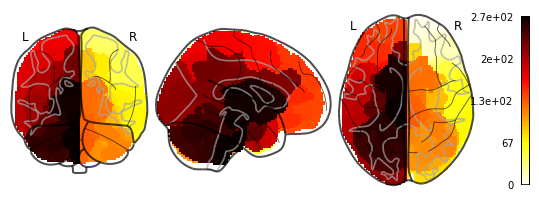

In [17]:
#Import brain plot libraries

from nilearn.plotting import plot_glass_brain
from nltools.data import Brain_Data
from nltools.mask import expand_mask, roi_to_brain



mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
mask_x = expand_mask(mask)
    
img = roi_to_brain(pd.Series(np.arange(0,268)), mask_x)
plot_glass_brain(img.to_nifti(), colorbar = True, plot_abs=False)#, cmap = 'Set1')

#from nilearn import plotting
#plotting.plot_stat_map(img.to_nifti())

- Most of the whole-brain analyses are done on the sigmoid nodes alone. Broadly, I plotted various parameters for each sigmoid node that was either a social/nonsocial decider node
- Also plotted mean values across nodes of the same tyopes in some cases

In [31]:
# Here, we adjust params for amp, take diffs between Yes and No and store nodes with the highest values

#def plot_params_fn(fn=0,thr=.001, nrep=1000):
import mne

fn = 0 # CHANGE FUNCTION HERE
thr = .05
nrep = 1000

t=np.empty((268,4)) # dim: nodes,params
t[:]=np.nan
p=np.empty((268,4))
p[:]=np.nan
mean_diff=np.empty((268,4))
mean_diff[:]=np.nan

yes_grp_all=np.empty((268,4)) # param values for the Ye group
yes_grp_all[:]=np.nan
no_grp_all=np.empty((268,4)) # param values for the Ye group
no_grp_all[:]=np.nan

yes_unc=np.empty((268,4)) # param values unocrrected for amplitude
no_unc=np.empty((268,4))

nparam=3 if fn<3 else 4

nodes= np.where((fns_same==1)&(df_best_fns["YesResponders"].values==fn))[0]
print(f'Fn:{fn}, nr. of nodes{len(nodes)}')

yes_all = np.load(os.path.join(working_dir,'median_yes_params_bs'+str(nrep)+'iters.npy')) # load bootstrapped parameters
no_all = np.load(os.path.join(working_dir,'median_no_params_bs'+str(nrep)+'iters.npy'))

for pnum in range(nparam):
    for n in nodes:
        yes_grp = yes_all[:,n,pnum]
        yes_unc[n,pnum] = np.nanmean(yes_all[:,n,pnum])
        no_grp = no_all[:,n,pnum]
        no_unc[n,pnum] = np.nanmean(no_all[:,n,pnum])
        
        if fn%2==0: #sigmoid, gaussian
            if pnum > 0:
                yes_grp = np.divide(yes_grp,abs(yes_all[:,n,0]))
                no_grp = np.divide(no_grp,abs(no_all[:,n,0]))
        elif fn==1:#sine
            if pnum ==1:
                yes_grp = np.divide(yes_grp,abs(yes_all[:,n,0]))
                no_grp = np.divide(no_grp,abs(no_all[:,n,0]))
        else: # delayed sine
            if pnum > 1:
                yes_grp = np.divide(yes_grp,abs(yes_all[:,n,1]))
                no_grp = np.divide(no_grp,abs(no_all[:,n,1]))
                
        yes_grp_all[n,pnum] = np.nanmean(yes_grp)
        no_grp_all[n,pnum] = np.nanmean(no_grp)
        t[n,pnum],p[n,pnum] = stats.ttest_ind(yes_grp,no_grp)
        
        if fn %2==0:
            if pnum==0: # sine and delayed sine amplitudes are always positive
                mean_diff[n,pnum]= abs(np.nanmean(yes_grp))- abs(np.nanmean(no_grp))
            else:
                mean_diff[n,pnum]= np.nanmean(yes_grp)- np.nanmean(no_grp)
                
        else:
            mean_diff[n,pnum]= np.nanmean(yes_grp)- np.nanmean(no_grp)

    _, p[nodes,pnum] = mne.stats.fdr_correction(p[nodes,pnum], thr)# FDR correction

mean_diff[p>thr]= np.nan # assign nan to suprathreshold nodes (for plotting)
mean_diff[abs(mean_diff)>3000]= np.nan # too high param value diffs are removed here

p_signodes = [] # nodes with significant Yes-No diffs
fns_sig = []
params_sig=[]
for pnum in range(nparam):
    p_signodes.append(np.where(~np.isnan(mean_diff[:,pnum]))[0])
    #p_signodes.append(np.where(mean_diff[:,pnum]<thr)[0])
    fns_sig.append(fn)
    params_sig.append(pnum)
params_sig = np.array(params_sig)
fns_sig = np.array(fns_sig)
#p_signodes

nodes_list_pos = []
nodes_list_neg = []
for pnum in range(nparam):
    sig_nodes = np.where(~np.isnan(mean_diff[:,pnum]))[0]
    df = pd.DataFrame({'nodes':sig_nodes,'amp':mean_diff[sig_nodes,pnum]})
    # highest and lowest nodes for each param
    nodes_list_pos.append([df.sort_values(by = 'amp',ascending=False).nodes[:10].values,df.sort_values(by = 'amp',ascending=False).amp[:10].values])
    nodes_list_neg.append([df.sort_values(by = 'amp',ascending=True).nodes[:10].values,df.sort_values(by = 'amp',ascending=True).amp[:10].values])




Fn:0, nr. of nodes167


Text(0.5, 1.0, 'Distribution of centres\nacross nodes')

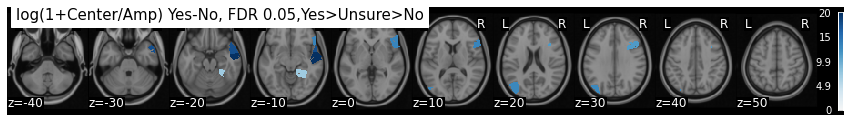

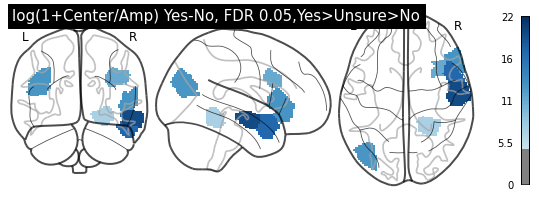

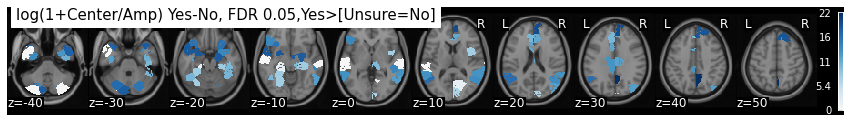

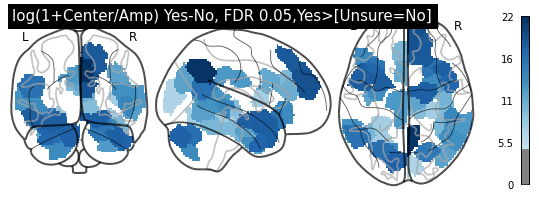

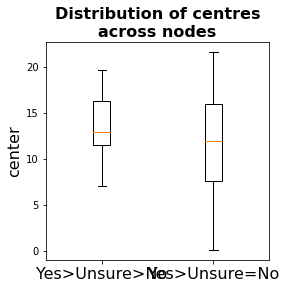

In [32]:
# Plot mean centre for yes responders (a) for each node of type social accumulator and decider. and 
#(b) boxplot across nodes

fn =0
pnum=1

val = np.nanmean(yes_all[:,:,pnum],axis=0) # mean yes response
rois_all = [] # to store nonNaNrois dir each node tyoe
for node_type in[0,1]:
    rois = np.empty((268,))
    rois[:]=np.nan
    rois[comparisons_all.item()['Nodes'][node_type]]= val[comparisons_all.item()['Nodes'][node_type]]
    rois_all.append(rois[~np.isnan(rois)])
    img = roi_to_brain(pd.Series(rois), mask_x)
    title_str = props[fn][pnum] + ', FDR ' +str(thr)+','+ comparisons_all.item()['lbls'][node_type]
    
    if ((fn <3) and (pnum==0)) or ((fn==3) and (pnum==1)):
        img.plot(colorbar=True, title = title_str, cmap = 'RdBu_r',symmetric_cbar = False)
        plot_glass_brain(img.to_nifti(), title = title_str,colorbar = True, plot_abs=False, cmap = 'RdBu_r')


    else:
        img.plot(colorbar=True, title = title_str, cmap = 'RdBu',symmetric_cbar = False)
        plot_glass_brain(img.to_nifti(), title = title_str ,colorbar = True, plot_abs=False, cmap = 'RdBu',threshold =5,
                         vmax=22)

plt.figure(5,figsize=(4,4))
plt.boxplot(rois_all)
plt.xticks(np.arange(1,3),['Yes>Unsure>No','Yes>Unsure=No'],fontsize =16)
plt.ylabel('center',fontsize =16)
plt.title('Distribution of centres\nacross nodes',fontsize =16, fontweight='bold')

Fn:0, nr. of nodes167


(0.037535964150640755, 0.25178696642357934)

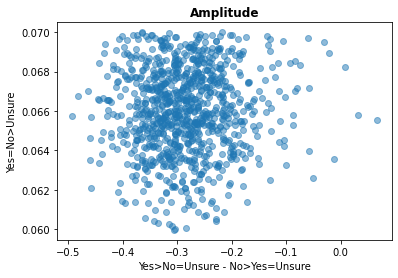

In [43]:
# to compare mean activity  aross nodes between social deciders, nonsocial deciders and any deciders, 
# all in Yes responders

import mne

fn = 0 # CHANGE FUNCTION HERE
thr = .05
nrep = 1000

t=np.empty((268,4)) # dim: nodes,params
t[:]=np.nan
p=np.empty((268,4))
p[:]=np.nan

yes_grp=np.empty((1000,3)) # param values for the Ye group
yes_grp[:]=np.nan

no_grp=np.empty((1000,3)) # param values for the Ye group
no_grp[:]=np.nan

any_grp=np.empty((1000,3)) # param values for the Ye group
any_grp[:]=np.nan


yes_unc=np.empty((268,4)) # param values unocrrected for amplitude
no_unc=np.empty((268,4))


nparam=3 if fn<3 else 4

nodes= np.where((fns_same==1)&(df_best_fns["YesResponders"].values==fn))[0]
print(f'Fn:{fn}, nr. of nodes{len(nodes)}')

yes_all = np.load(os.path.join(working_dir,'median_yes_params_bs'+str(nrep)+'iters.npy'))
no_all = np.load(os.path.join(working_dir,'median_no_params_bs'+str(nrep)+'iters.npy'))

yes_nodes = comparisons_all.item()['Nodes'][1]
no_nodes = comparisons_all.item()['Nodes'][3]
yes_or_no_nodes = comparisons_all.item()['Nodes'][4]

for pnum in range(nparam):
    for iter in range(1000):
        if fn%2==0: #sigmoid, gaussian
            if pnum > 0:
                yes_grp[iter,pnum] = np.nanmean(np.divide(yes_all[iter,yes_nodes,pnum], yes_all[iter,yes_nodes,0]))
                
                no_grp[iter,pnum] =  np.nanmean(np.divide(yes_all[iter,no_nodes, pnum], yes_all[iter, no_nodes,0]))
                
                any_grp[iter,pnum] = np.nanmean(np.divide(yes_all[iter,yes_or_no_nodes,pnum],
                                                         yes_all[iter,yes_or_no_nodes,0]))
            else:
                yes_grp[iter,pnum] = np.nanmean(yes_all[iter,yes_nodes,pnum])
                
                no_grp[iter,pnum] =  np.nanmean(yes_all[iter,no_nodes, pnum])
                
                any_grp[iter,pnum] = np.nanmean(yes_all[iter,yes_or_no_nodes,pnum])
               
pnum=0
#outlier = any_grp[:,pnum]>1000
outlier = any_grp[:,pnum]>.07
plt.plot(yes_grp[~outlier,pnum]-no_grp[~outlier,pnum], any_grp[~outlier,pnum],ls='None',marker='o', alpha =.5)
plt.xlabel('Yes>No=Unsure - No>Yes=Unsure')
plt.ylabel('Yes=No>Unsure')
plt.title('Amplitude', fontweight = 'bold')
stats.pearsonr(yes_grp[~outlier,pnum]-no_grp[~outlier,pnum],any_grp[~outlier,pnum])

                                                             

nsocial decider= 53 nnonsocial decider= 20


Ttest_indResult(statistic=-0.6419240650042224, pvalue=0.5246778845564641)

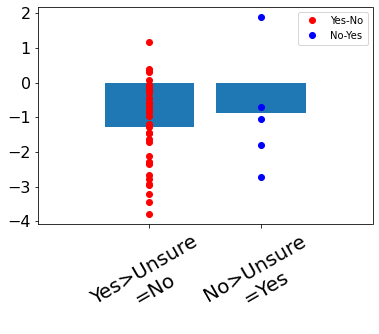

In [40]:
# Yes-No or No-Yes for social/nonsocial deciders (1,3) or accumulators(0,2)
pnum=2
soc_decider = DV[comparisons_all.item()['Nodes'][1],pnum]
nonsoc_decider = DV[comparisons_all.item()['Nodes'][3],pnum]
print('nsocial decider=',len(soc_decider),'nnonsocial decider=',len(nonsoc_decider))
plt.plot(np.ones((len(soc_decider),)),soc_decider,ls = "None",marker = 'o',color='r'
        ,label ='Yes-No')
plt.plot(1+np.ones((len(nonsoc_decider),)),-nonsoc_decider,ls = "None",marker = 'o',
         color='b', label = 'No-Yes')
plt.xticks(1+np.arange(2),['Yes>Unsure\n=No','No>Unsure\n=Yes'],rotation=30,fontsize =20)
plt.bar(1+np.arange(2),[np.nanmean(soc_decider),np.nanmean(-nonsoc_decider)])
plt.yticks(fontsize=16)
plt.xlim(0,3)
plt.legend()
stats.ttest_ind(soc_decider,-nonsoc_decider, nan_policy='omit')


param, max 0 :  [52]
param, min 0 :  52
param, min 1 :  [ 51  52  87  91 135 234 266]
param, min 1 :  52
param, min 2 :  [  1  17  51  52  59  87  89 127 133 194 201 233 262]
param, min 2 :  89


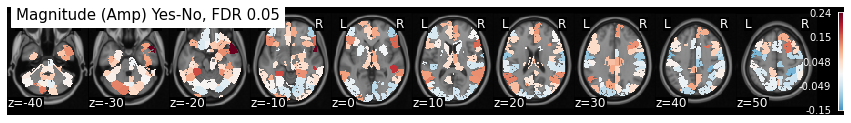

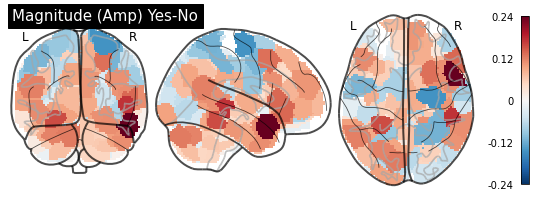

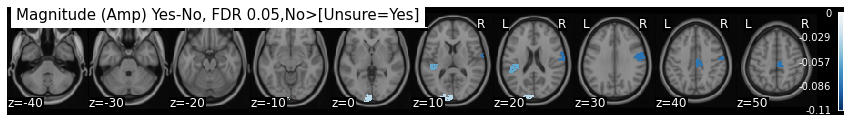

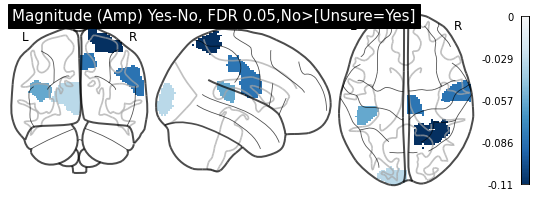

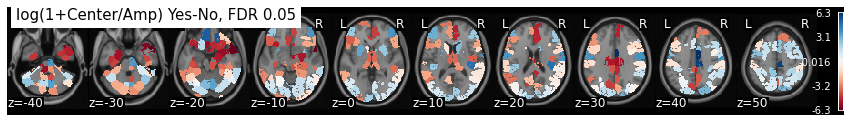

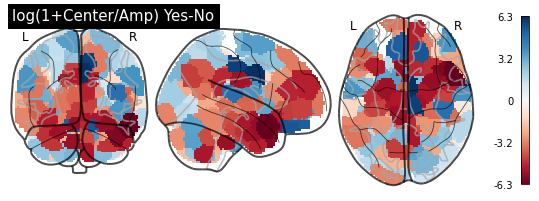

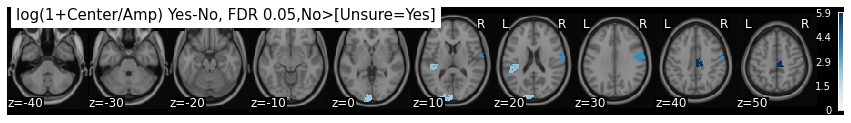

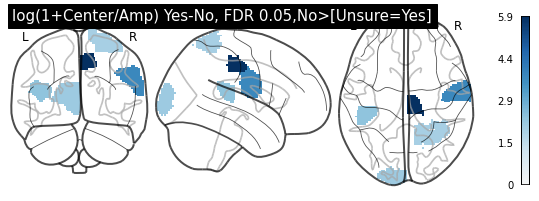

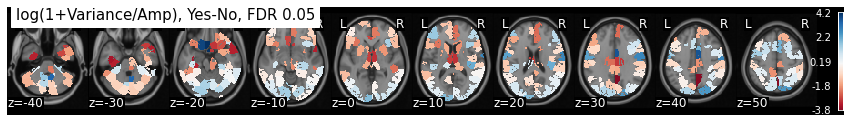

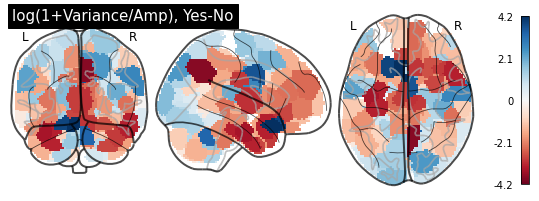

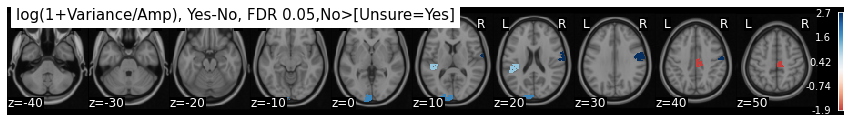

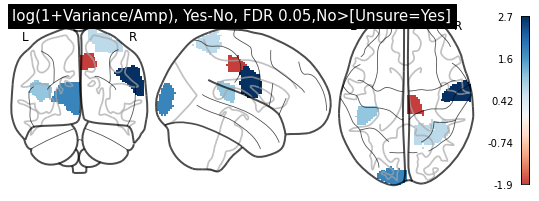

In [39]:
# Yes-No for all nodes or nodes of type node_type


mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
mask_x = expand_mask(mask)


nparam=3 if fn<3 else 4


#print(fn)
DV = np.empty((268,nparam))
DV[:]=np.nan
for pnum in range(nparam):
    if (fn<3):
        if pnum == 0:
            print('param, max',pnum,': ',np.where(mean_diff[:,pnum]>.8*np.nanmax(mean_diff[:,pnum]))[0])
            print('param, min',pnum,': ',np.nanargmax(mean_diff[:,pnum]))

        else:
            print('param, min',pnum,': ',np.where(mean_diff[:,pnum]<.3*np.nanmin(mean_diff[:,pnum]))[0])
            print('param, min',pnum,': ',np.nanargmin(mean_diff[:,pnum]))

    #img = roi_to_brain(pd.Series(mean_diff[:,pnum]), mask_x)
    
    if ((fn%2==0 and pnum > 0) or (fn==1 and pnum ==1)):
        DV[:,pnum] = np.multiply(np.sign(mean_diff[:,pnum]),np.log(1+abs(mean_diff[:,pnum])))
        
    else:
        DV[:,pnum] = mean_diff[:,pnum]
    
    img = roi_to_brain(pd.Series(DV[:,pnum]), mask_x)
    #img.plot(colorbar=True, title = functions_list[fn] + props[fn][pnum], cmap = 'RdBu_r',symmetric_cbar = False)
    #print('pnum', pnum, 'max=',np.where(mean_diff[:,pnum]>.1*np.nanmax(mean_diff[:,pnum]))[0])
    #print('pnum', pnum, 'min=',np.where(mean_diff[:,pnum]<.5*np.nanmin(mean_diff[:,pnum]))[0])
    if ((fn <3) and (pnum==0)) or ((fn==3) and (pnum==1)):
        img.plot(colorbar=True, title = props[fn][pnum] + ', FDR ' +str(thr), cmap = 'RdBu_r',symmetric_cbar = False)
        plot_glass_brain(img.to_nifti(), title = props[fn][pnum],colorbar = True, plot_abs=False, cmap = 'RdBu_r')
    else:
        img.plot(colorbar=True, title = props[fn][pnum] + ', FDR ' +str(thr), cmap = 'RdBu',symmetric_cbar = False)
        plot_glass_brain(img.to_nifti(), title = props[fn][pnum] ,colorbar = True, plot_abs=False, cmap = 'RdBu')

    
    #ultimate soial decider (1),nonsocial decider
    node_type = 3
    rois = np.empty((268,))
    rois[:]=np.nan
    rois[comparisons_all.item()['Nodes'][node_type]]=DV[comparisons_all.item()['Nodes'][node_type],pnum]
    #diss_nodes = 1-corr_yn
    #rois[diss_nodes < .05] = np.nan 
    img = roi_to_brain(pd.Series(rois), mask_x)
    
    title_str = props[fn][pnum] + ', FDR ' +str(thr)+','+ comparisons_all.item()['lbls'][node_type]
  
    if ((fn <3) and (pnum==0)) or ((fn==3) and (pnum==1)):
        img.plot(colorbar=True, title = title_str, cmap = 'RdBu_r',symmetric_cbar = False)
        plot_glass_brain(img.to_nifti(), title = title_str,colorbar = True,symmetric_cbar = False, plot_abs=False, cmap = 'RdBu_r')


    else:
        img.plot(colorbar=True, title = title_str, cmap = 'RdBu',symmetric_cbar = False)
        plot_glass_brain(img.to_nifti(), title = title_str ,colorbar = True, symmetric_cbar = False,plot_abs=False, cmap = 'RdBu')



#return p_signodes,params_sig, fns_sig, mean_diff,nodes_list_pos,nodes_list_neg

#p_signodes,params_sig, fns_sig, mean_diff,nodes_list_pos,nodes_list_neg = plot_params_fn()




In [17]:
#mean_yes = np.nanmean(tc_yes_resh,axis=0)
#mean_no = np.nanmean(tc_no_resh,axis=0)


vidnames = ["COAXING-B", "BILLIARD-A", "DRIFTING-A", "Fishing", 
            "Random mechanical", "Scaring", "SEDUCING-B", "STAR-A", 
            "SURPRISING-B", "TENNIS-A"]


In [55]:
# to bootstrap correlations between the yes and No fgroups

subs_yes = []# to store subs selected for each iteration as a list. useful if we want to subsample and make sure 
subs_no = []#

median_corr_bs = np.empty((nrep,268,2)) # r,p
median_corr_bs[:] = np.nan

start = time.time()

#if __name__ == '__main__':
#    pool = Pool(processes=cpu_count())

for iter in range(nrep):
    if iter%10 == 0:
        print('Iter', iter,', time elapsed',(time.time()- start)/60,'mins')

    samples_yes = np.random.choice(tc_yes_resh.shape[0],size = tc_yes_resh.shape[0], replace=True)
    samples_yes = [int(i) for i in samples_yes]
    median_yes = np.nanmedian(tc_yes_resh[samples_yes,:,:], axis = 0) # average across trials to get 268*28
    subs_yes.append(sub_id_yes[samples_yes])

    samples_no = np.random.choice(tc_no_resh.shape[0],size = tc_no_resh.shape[0], replace=True)
    samples_no = [int(i) for i in samples_no]
    median_no = np.nanmedian(tc_no_resh[samples_no,:,:], axis = 0) # average across trials to get 268*28
    subs_no.append(sub_id_no[samples_no])


    #tcs = [y for y in median_yes]
    #res = pool.map(function_fit,tcs)
    #res = Parallel(n_jobs=10)(delayed(function_fit)(y) for y in mean_yes)
    # res is a list of lists. res[node_nr] contains 4 variables returned by logfit_fn, viz.  
    # params_best, param_keys, r2, result.aic
    # params_best returns the 3 params from logfit
    
    for n in range(268):
        r,p = stats.pearsonr(median_yes[n,:],median_no[n,:])
        #corr_yn[n] = r if p < .05 else np.nan
        median_corr_bs[iter, n,0] = r
        median_corr_bs[iter,n,1] = p

np.save('median_corr_bs.npy',median_corr_bs)


print('total time for yes:',(time.time()-start)/60,'mins')   
#Audio(data,rate=framerate,autoplay= True)



Iter 0 , time elapsed 8.368492126464844e-06 mins
Iter 10 , time elapsed 0.39656566778818764 mins
Iter 20 , time elapsed 0.8337386012077331 mins
Iter 30 , time elapsed 1.2747777342796325 mins
Iter 40 , time elapsed 1.7134242177009582 mins
Iter 50 , time elapsed 2.1481993993123374 mins
Iter 60 , time elapsed 2.5765504678090414 mins
Iter 70 , time elapsed 3.0125137329101563 mins
Iter 80 , time elapsed 3.4412137707074484 mins
Iter 90 , time elapsed 3.880088500181834 mins
Iter 100 , time elapsed 4.32659330368042 mins
Iter 110 , time elapsed 4.766269099712372 mins
Iter 120 , time elapsed 5.214817066987355 mins
Iter 130 , time elapsed 5.64346615076065 mins
Iter 140 , time elapsed 6.093813534577688 mins
Iter 150 , time elapsed 6.551482919851939 mins
Iter 160 , time elapsed 7.020620600382487 mins
Iter 170 , time elapsed 7.477151135603587 mins
Iter 180 , time elapsed 7.932915600140889 mins
Iter 190 , time elapsed 8.382342366377513 mins
Iter 200 , time elapsed 8.847922885417939 mins
Iter 210 , ti

In [2]:
median_corr_bs = np.load('median_corr_bs.npy')

median_corr_bs.shape

(1000, 268, 2)

In [11]:
mean_diss = np.zeros((268,))
for n in range(268):
    t,p = stats.ttest_1samp(median_corr_bs[:,n,0],0, nan_policy='omit')
    if p < .05:
        mean_diss[n] = np.nanmedian(median_corr_bs[:,n,:])
        
# Plotting mean dissimilaroty
rois = np.empty((268,)i)
rois[:] = np.nan
rois = 1-mean_diss
img = roi_to_brain(pd.Series(rois), mask_x)
title_str = 'Dissimilarity'
img.plot(colorbar=True, title = title_str, cmap = 'RdBu_r',symmetric_cbar = False)
plot_glass_brain(img.to_nifti(), title = title_str,colorbar = True, plot_abs=False, symmetric_cbar=False,cmap = 'RdBu_r')


     

In [ ]:
img = roi_to_brain(pd.Series(median_corr_bs), mask_x)

img.plot(colorbar=True, title = f'{vidnames[movie_ind][:4]},Dissimilarity mean yes vs. no', cmap = 'RdBu_r',symmetric_cbar = False,
            threshold_upper = 1)
plot_glass_brain(img.to_nifti(), title = f'{vidnames[movie_ind][:4]},Dissimilarity mean yes vs. no',colorbar = True, plot_abs=False, 
                 cmap = 'RdBu_r')


threshold is ignored for simple axial plots


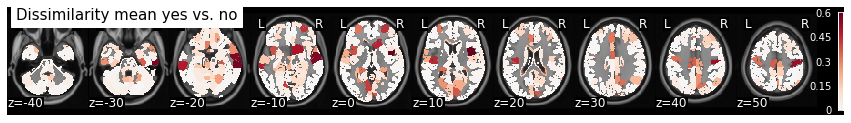

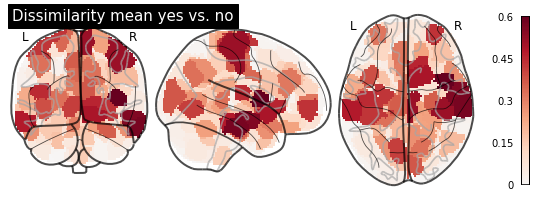

In [23]:
# computing dissimilarity withoutt bootstrapping
mean_yes = np.nanmean(tc_yes_resh,axis=0)
mean_no = np.nanmean(tc_no_resh,axis=0)

corr_yn=np.empty((268,))
corr_yn[:] = np.nan
for n in range(268):
    r,p = stats.pearsonr(mean_yes[n,:],mean_no[n,:])
    corr_yn[n] = r if p < .05 else np.nan

img = roi_to_brain(pd.Series(1-corr_yn), mask_x)

img.plot(colorbar=True, title = f'Dissimilarity mean yes vs. no', cmap = 'RdBu_r',symmetric_cbar = False,
            threshold_upper = 1)
plot_glass_brain(img.to_nifti(), title = f'Dissimilarity mean yes vs. no',colorbar = True, plot_abs=False, 
                 cmap = 'RdBu_r')




threshold is ignored for simple axial plots


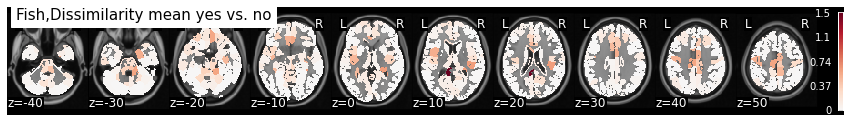

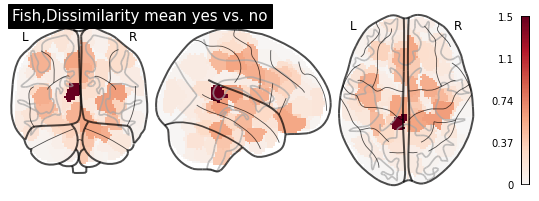

In [20]:
# Plotting 1-corr for each movie and node
#goal: to see if the individual movies show the same activations as in the group(esp in lower level areas)
#for movie_ind in range(10):
movie_ind =3
mean_yes = np.nanmean(movie_tc_yes[:,:,:,movie_ind],axis=0)
mean_no = np.nanmean(movie_tc_no[:,:,:,movie_ind],axis=0)

corr_yn=np.empty((268,))
corr_yn[:] = np.nan
for n in range(268):
    r,p = stats.pearsonr(mean_yes[n,:],mean_no[n,:])
    corr_yn[n] = r if p < .05 else np.nan

img = roi_to_brain(pd.Series(1-corr_yn), mask_x)

img.plot(colorbar=True, title = f'{vidnames[movie_ind][:4]},Dissimilarity mean yes vs. no', cmap = 'RdBu_r',symmetric_cbar = False,
            threshold_upper = 1)
plot_glass_brain(img.to_nifti(), title = f'{vidnames[movie_ind][:4]},Dissimilarity mean yes vs. no',colorbar = True, plot_abs=False, 
                 cmap = 'RdBu_r')



167


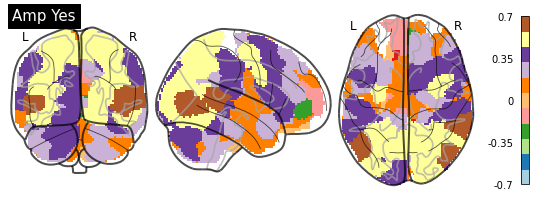

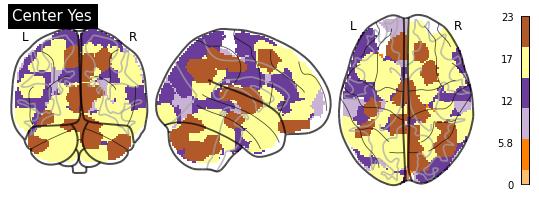

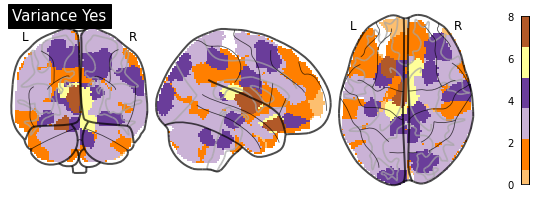

In [41]:
# Yes responses plot discretised
import mne
import numpy as np
import pandas as pd
from scipy import stats

fn = 0
thr = .001
nrep = 1000

#print(fn)
t=np.empty((268,4)) # fns, nodes,params
t[:]=np.nan
p=np.empty((268,4))
p[:]=np.nan
mean_diff=np.empty((268,4))
mean_diff[:]=np.nan
yes_grp_all=np.empty((268,4))
yes_grp_all[:]=np.nan
yes_unc=np.empty((268,4))
yes_unc[:]=np.nan

df_best_fns = pd.read_csv('Best_functions.csv')
#df_best_fns.head()
fns_same = df_best_fns["YesResponders"].values==df_best_fns["NoResponders"].values


nparam=3 if fn<3 else 4
nodes= np.where((fns_same==1)&(df_best_fns["YesResponders"].values==fn))[0]
print(len(nodes))
yes_all = np.load('median_yes_params_bs'+str(nrep)+'iters.npy')
no_all = np.load('median_no_params_bs'+str(nrep)+'iters.npy')

for pnum in range(nparam):
    for n in nodes:
        yes_grp = yes_all[:,n,pnum]
        yes_unc[n,pnum] = np.nanmean(yes_all[:,n,pnum])
        no_grp = no_all[:,n,pnum]
        no_unc[n,pnum] = np.nanmean(no_all[:,n,pnum])
        
        if fn%2==0:
            if pnum > 0:
                yes_grp = np.divide(yes_grp,abs(yes_all[:,n,0]))
                no_grp = np.divide(no_grp,abs(no_all[:,n,0]))
        elif fn==1:
            if pnum ==1:
                yes_grp = np.divide(yes_grp,abs(yes_all[:,n,0]))
                no_grp = np.divide(no_grp,abs(no_all[:,n,0]))
        else:
            if pnum > 1:
                yes_grp = np.divide(yes_grp,abs(yes_all[:,n,1]))
                no_grp = np.divide(no_grp,abs(no_all[:,n,1]))
        yes_grp_all[n,pnum] = np.nanmean(yes_grp)
        t[n,pnum],p[n,pnum] = stats.ttest_ind(yes_grp,no_grp)
        
from nltools.data import Brain_Data
from nltools.mask import expand_mask, roi_to_brain


mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
mask_x = expand_mask(mask)


nparam=3 if fn<3 else 4

props = [['Amp Yes', 'Center Yes', 'Variance Yes'],['Amplitude', 'Frequency/Amp', 'Phase'],
         ['Mag.(AYes-ANo)', 'log(Center/Amp)', 'log(Variance/Amp)'],['Step_onset','Amplitude', 'Frequency', 'Phase']]


#print(fn)
DV = np.empty((268,nparam))
DV[:]=np.nan
for pnum in range(nparam):
    #print('param, min',pnum,': ',np.nanargmin(mean_diff[:,pnum]))

    #img = roi_to_brain(pd.Series(mean_diff[:,pnum]), mask_x)
    
    #if ((fn%2==0 and pnum > 0) or (fn==1 and pnum ==1)):
    #    DV[:,pnum] = np.multiply(np.sign(yes_grp_all[:,pnum]),np.log(1+abs(yes_grp_all[:,pnum])))
        
    #else:
    #    DV[:,pnum] = yes_grp_all[:,pnum]
    
    DV[:,pnum] = yes_unc[:,pnum]
    
    img = roi_to_brain(pd.Series(DV[:,pnum]), mask_x)
    #img.plot(colorbar=True, title = functions_list[fn] + props[fn][pnum], cmap = 'RdBu_r',symmetric_cbar = False)
    #print('pnum', pnum, 'max=',np.where(mean_diff[:,pnum]>.1*np.nanmax(mean_diff[:,pnum]))[0])
    #print('pnum', pnum, 'min=',np.where(mean_diff[:,pnum]<.5*np.nanmin(mean_diff[:,pnum]))[0])
    #plot_glass_brain(img.to_nifti(), title = props[fn][pnum],colorbar = True, plot_abs=False, cmap = 'Paired')

    if pnum ==1 :
        plot_glass_brain(img.to_nifti(), title = props[fn][pnum],colorbar = True, plot_abs=False, cmap = 'Paired', vmin = 0, vmax = 23)
    elif pnum ==2:
        plot_glass_brain(img.to_nifti(), title = props[fn][pnum],colorbar = True, plot_abs=False, cmap = 'Paired', vmin = 0, vmax = 8)
    else:
        plot_glass_brain(img.to_nifti(), title = props[fn][pnum],colorbar = True, plot_abs=False, cmap = 'Paired', vmin = -.7, vmax = .7)


    #else:
        #img.plot(colorbar=True, title = props[fn][pnum] + ', FDR ' +str(thr), cmap = 'RdBu',symmetric_cbar = False)
        #plot_glass_brain(img.to_nifti(), title = props[fn][pnum] ,colorbar = True, plot_abs=False, cmap = 'RdBu')


#return p_signodes,params_sig, fns_sig, mean_diff,nodes_list_pos,nodes_list_neg

#p_signodes,params_sig, fns_sig, mean_diff,nodes_list_pos,nodes_list_neg = plot_params_fn()




167


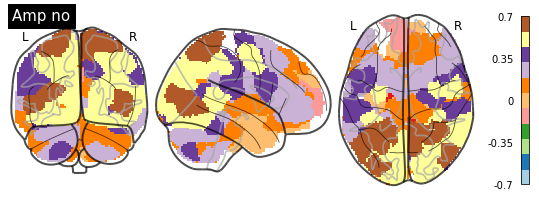

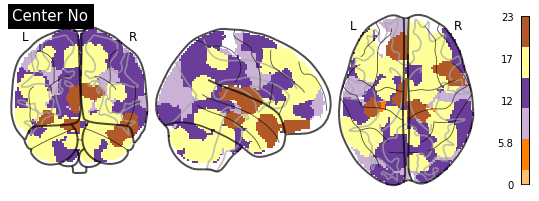

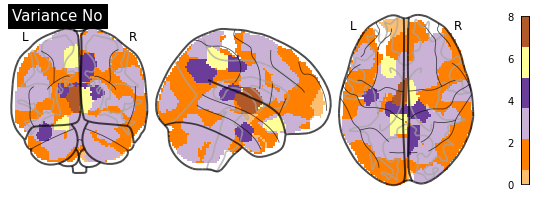

In [43]:
# Yes responses plot discretised
#no_unc = uncorrected centre (to see more meaningful centre values here)
import mne
import numpy as np
import pandas as pd
from scipy import stats

fn = 0
thr = .001
nrep = 1000

#print(fn)
t=np.empty((268,4)) # fns, nodes,params
t[:]=np.nan
p=np.empty((268,4))
p[:]=np.nan
mean_diff=np.empty((268,4))
mean_diff[:]=np.nan
no_grp_all=np.empty((268,4))
no_grp_all[:]=np.nan
no_unc=np.empty((268,4))
no_unc[:]=np.nan



df_best_fns = pd.read_csv('Best_functions.csv')
#df_best_fns.head()
fns_same = df_best_fns["YesResponders"].values==df_best_fns["NoResponders"].values


nparam=3 if fn<3 else 4
nodes= np.where((fns_same==1)&(df_best_fns["YesResponders"].values==fn))[0]
print(len(nodes))
yes_all = np.load('median_yes_params_bs'+str(nrep)+'iters.npy')
no_all = np.load('median_no_params_bs'+str(nrep)+'iters.npy')

for pnum in range(nparam):
    for n in nodes:
        yes_grp = yes_all[:,n,pnum]
        yes_unc[n,pnum] = np.nanmean(yes_all[:,n,pnum])
        no_grp = no_all[:,n,pnum]
        no_unc[n,pnum] = np.nanmean(no_all[:,n,pnum])
        
        if fn%2==0:
            if pnum > 0:
                yes_grp = np.divide(yes_grp,abs(yes_all[:,n,0]))
                no_grp = np.divide(no_grp,abs(no_all[:,n,0]))
        elif fn==1:
            if pnum ==1:
                yes_grp = np.divide(yes_grp,abs(yes_all[:,n,0]))
                no_grp = np.divide(no_grp,abs(no_all[:,n,0]))
        else:
            if pnum > 1:
                yes_grp = np.divide(yes_grp,abs(yes_all[:,n,1]))
                no_grp = np.divide(no_grp,abs(no_all[:,n,1]))
        yes_grp_all[n,pnum] = np.nanmean(no_grp)
        no_grp_all[n,pnum] = np.nanmean(no_grp)
        t[n,pnum],p[n,pnum] = stats.ttest_ind(yes_grp,no_grp)
        
from nltools.data import Brain_Data
from nltools.mask import expand_mask, roi_to_brain


mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
mask_x = expand_mask(mask)


nparam=3 if fn<3 else 4

props = [['Amp no', 'Center No', 'Variance No'],['Amplitude', 'Frequency/Amp', 'Phase'],
         ['Mag.(AYes-ANo)', 'log(Center/Amp)', 'log(Variance/Amp)'],['Step_onset','Amplitude', 'Frequency', 'Phase']]


#print(fn)
DV = np.empty((268,nparam))
DV[:]=np.nan
for pnum in range(nparam):
    #print('param, min',pnum,': ',np.nanargmin(mean_diff[:,pnum]))

    #img = roi_to_brain(pd.Series(mean_diff[:,pnum]), mask_x)
    
    #if ((fn%2==0 and pnum > 0) or (fn==1 and pnum ==1)):
    #    DV[:,pnum] = np.multiply(np.sign(no_grp_all[:,pnum]),np.log(1+abs(no_grp_all[:,pnum])))
        
    #else:
    #    DV[:,pnum] = no_grp_all[:,pnum]
    DV[:,pnum] = no_unc[:,pnum]
    img = roi_to_brain(pd.Series(DV[:,pnum]), mask_x)
    #img.plot(colorbar=True, title = functions_list[fn] + props[fn][pnum], cmap = 'RdBu_r',symmetric_cbar = False)
    #print('pnum', pnum, 'max=',np.where(mean_diff[:,pnum]>.1*np.nanmax(mean_diff[:,pnum]))[0])
    #print('pnum', pnum, 'min=',np.where(mean_diff[:,pnum]<.5*np.nanmin(mean_diff[:,pnum]))[0])
    if pnum ==1 :
        plot_glass_brain(img.to_nifti(), title = props[fn][pnum],colorbar = True, plot_abs=False, cmap = 'Paired', vmin = 0, vmax = 23)
    elif pnum ==2:
        plot_glass_brain(img.to_nifti(), title = props[fn][pnum],colorbar = True, plot_abs=False, cmap = 'Paired', vmin = 0, vmax = 8)
    else:
        plot_glass_brain(img.to_nifti(), title = props[fn][pnum],colorbar = True, plot_abs=False, cmap = 'Paired', vmin = -.7, vmax = .7)


    #else:
        #img.plot(colorbar=True, title = props[fn][pnum] + ', FDR ' +str(thr), cmap = 'RdBu',symmetric_cbar = False)
        #plot_glass_brain(img.to_nifti(), title = props[fn][pnum] ,colorbar = True, plot_abs=False, cmap = 'RdBu')


#return p_signodes,params_sig, fns_sig, mean_diff,nodes_list_pos,nodes_list_neg

#p_signodes,params_sig, fns_sig, mean_diff,nodes_list_pos,nodes_list_neg = plot_params_fn()


In [56]:
# to display nodes which have a keyword
keyword = 'middle_frontal'
for node_ind in range(268):
    dict = eval(shen268[str(node_ind +1)][0])
    if keyword in str.lower(dict['name']):
        print(dict['name'])


52.15% Frontal_Pole; 47.85% Middle_Frontal_Gyrus
33.82% Middle_Frontal_Gyrus; 33.82% Frontal_Pole; 26.94% Superior_Frontal_Gyrus; 5.42% no_label
98.80% Middle_Frontal_Gyrus
56.48% Frontal_Pole; 27.04% Inferior_Frontal_Gyrus_pars_triangularis; 14.09% Middle_Frontal_Gyrus
76.55% Middle_Frontal_Gyrus; 21.03% Inferior_Frontal_Gyrus_pars_opercularis
53.27% Superior_Frontal_Gyrus; 44.39% Middle_Frontal_Gyrus
75.69% Precentral_Gyrus; 20.60% Middle_Frontal_Gyrus
59.27% Precentral_Gyrus; 25.61% Middle_Frontal_Gyrus; 15.12% Superior_Frontal_Gyrus
48.26% Middle_Frontal_Gyrus; 32.27% Frontal_Pole; 19.47% Superior_Frontal_Gyrus
66.70% Middle_Frontal_Gyrus; 17.50% Inferior_Frontal_Gyrus_pars_triangularis; 8.86% Frontal_Pole; 6.14% Inferior_Frontal_Gyrus_pars_opercularis
97.89% Middle_Frontal_Gyrus
50.95% Precentral_Gyrus; 27.86% Middle_Frontal_Gyrus; 21.19% Inferior_Frontal_Gyrus_pars_opercularis
69.41% Superior_Frontal_Gyrus; 29.41% Middle_Frontal_Gyrus
65.05% Precentral_Gyrus; 33.77% Middle_Fronta

48.75% Right_Hippocampus
 37.63% Parahippocampal_Gyrus_posterior_division
 11.47% Temporal_Fusiform_Cortex_posterior_division 
-----


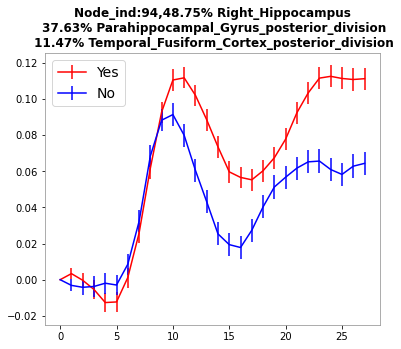

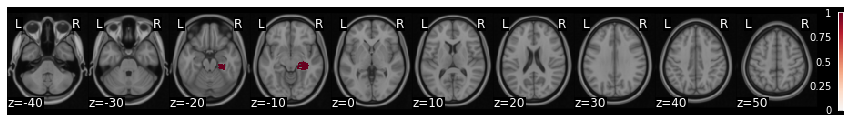

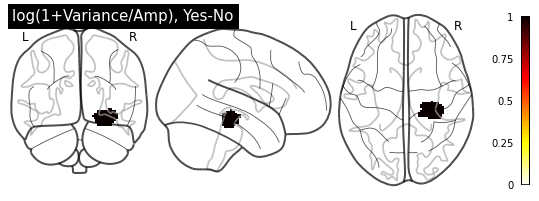

In [105]:
# to plot a single node

from nltools.data import Brain_Data
from nltools.mask import expand_mask, roi_to_brain
import matplotlib
matplotlib.rc('axes',edgecolor=[0.6,0.6,0.6])


mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
mask_x = expand_mask(mask)
    

node_ind = 94 #234


dict = eval(shen268[str(node_ind +1)][0])
nodename =dict['name']
nodename = nodename.split(';')
nodename = "\n".join(nodename)
print(nodename,'\n-----')


plt.figure(1,figsize = (6,5))
plt.errorbar(range(28),np.mean(tc_yes_resh[:,node_ind,:],axis=0),stats.sem(tc_yes_resh[:,node_ind,:],axis=0),
             color = 'r', label = 'Yes')
plt.errorbar(range(28),np.mean(tc_no_resh[:,node_ind,:],axis=0),stats.sem(tc_no_resh[:,node_ind,:],axis=0)
             ,color ='b', label = 'No')
#plt.title('node ind:'+str(node_ind))
#plt.title(nodename, fontweight = 'bold')
plot_poster = 0
if plot_poster==1:
    if node_ind == 52:
        plt.title('79.58% TP, 11.32% aMTG,\n6.53% aSTG',fontweight = 'bold')
    elif node_ind == 91:
        plt.title('40.77% Amygdala, 36.94% TP, \n9.46% Insula',fontweight = 'bold')
    elif node_ind == 89:
        plt.title('83.65% Precuneus, 16.35% PCC',fontweight = 'bold')
else:
    plt.title("Node_ind:"+str(node_ind)+','+nodename, fontweight = 'bold')
   # plt.xticks([])
   # plt.yticks([])
    
    
plt.legend(fontsize = 14)

nodes = np.empty((268,))
nodes[:]=np.nan
#sorted_ind = np.argsort(np.abs(res_all[0][:,0]))
#sorted_ind = sorted_ind[-3:][::-1]
#nodes[sorted_ind] = 1
#nodes[52]= 1
nodes[node_ind]= 1

img = roi_to_brain(nodes,mask_x)
img.plot(symmetric_cbar = False, colorbar=True,cmap='RdBu_r') 
plot_glass_brain(img.to_nifti(), title = props[fn][pnum],colorbar = True, plot_abs=False)




In [107]:
yes_all = np.load('median_yes_params_bs'+str(nrep)+'iters.npy')
no_all = np.load('median_no_params_bs'+str(nrep)+'iters.npy')

yes_all.shape

(1000, 268, 6)

In [80]:
flname = r"/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/shen_roi_info_files/xilin_268parc_labels.csv"
labels = pd.read_csv(flname)

from get_rois_info_fn import get_roi_info

df = get_roi_info(labels,nodes_list_pos, pnum)
df.head()


# chcek if this works later - should output the fihgest/lowest nodes based on nodes_list entered 

TypeError: get_roi_info() takes 2 positional arguments but 3 were given

Plotting params for Sigmoid...
param nr.  1


/dartfs-hpc/rc/home/z/f0053cz/.conda/envs/my_anaconda3_env/lib/python3.7/site-packages/nilearn/_utils/niimg.py:62: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  "Non-finite values detected. "


Top 10 Amplitude values:[ 52  53 197  15  29 246 182 252 150  64]
param nr.  2
Top 10 Center values:[  3  29 225  89   1  88 105 116  74 263]
param nr.  3
Top 10 Variance values:[116  74   1  91 134 211  29  52 236  35]


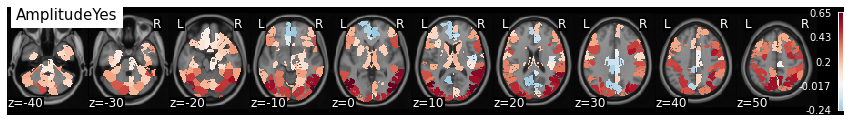

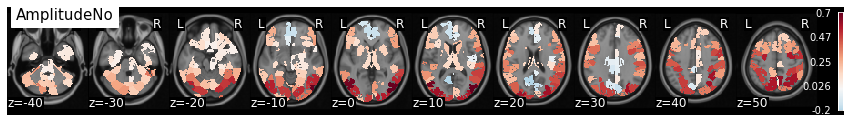

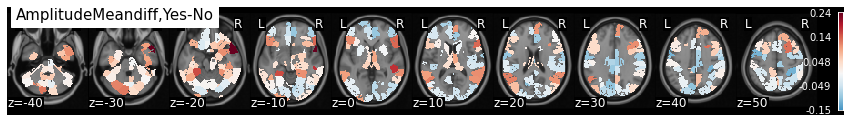

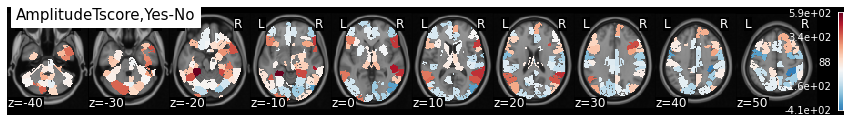

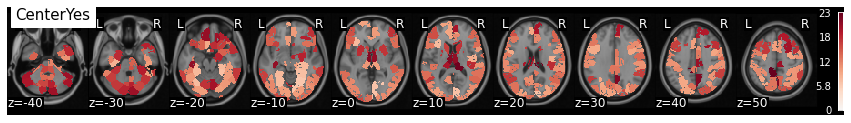

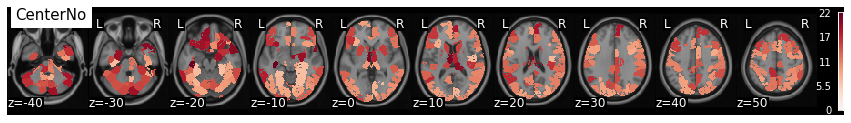

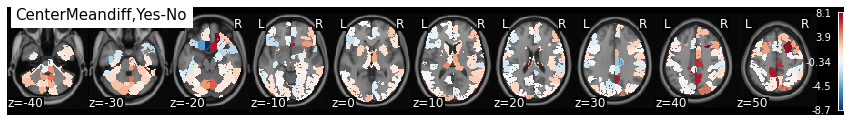

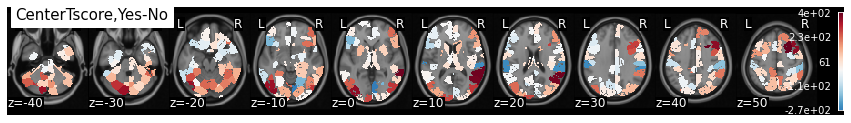

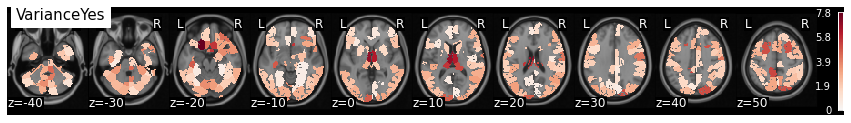

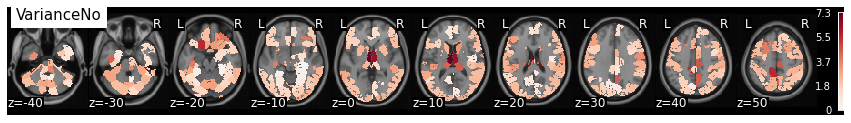

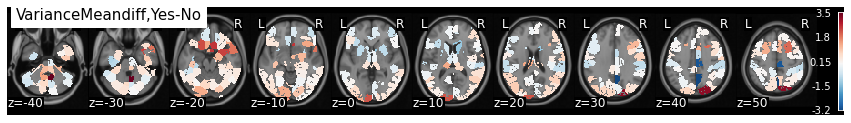

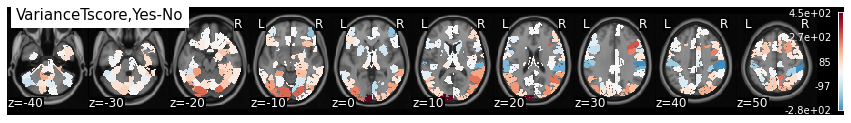

In [52]:
from nltools.data import Brain_Data
from nltools.mask import expand_mask, roi_to_brain

mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
mask_x = expand_mask(mask)

props = [['Amplitude', 'Center', 'Variance'],['Amplitude', 'Frequency', 'Phase'],
         ['Amplitude', 'Center', 'Variance'],['Step_onset','Amplitude', 'Frequency', 'Phase']]


fns_ID_yes = median_yes_params_bs[0,:,5]
fns_ID_no = median_no_params_bs[0,:,5]
fns_same = np.zeros((268,))
fns_same[fns_ID_yes == fns_ID_no] = 1



from nltools.data import Brain_Data
from nltools.mask import expand_mask, roi_to_brain

mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
mask_x = expand_mask(mask)

functions_list = ['Sigmoid','Sinusoidal','Gaussian','Delayed sine']
fn = 0
print(f'Plotting params for {functions_list[fn]}...')

n_args = 3 if fn < 3 else 4
maxnode_meandiff = np.empty((n_args,))
maxnode_tscore = np.empty((n_args,))

nodes = np.where((fns_same==1)&(fns_ID_yes==fn))[0]

res_all = []
rows_all = []
for pnum in range(n_args):#range(mean_yes_params.shape[2]): # nparams
    print('param nr. ',pnum+1)
    
    mat_yes = np.empty((nrep,268))
    mat_no = np.empty_like(mat_yes)
    
    mat_yes[:,nodes] = median_yes_params_bs[:,nodes,pnum]
    mat_no[:,nodes] = median_no_params_bs[:,nodes,pnum]
    
    res = Parallel(n_jobs=10)(delayed(compare_yn)(mat_yes[:,n],mat_no[:,n],'unpaired') for n in nodes)
    res = np.array(res)#rows:nnodes, cols: t,p-values[268,2]
    pvals = res[:,1]
    _, pval_corr = fdr_correct(pvals)
    rows = np.where(pval_corr < .05)[0]
    sig_nodes = nodes[rows]
    
    nodes1 = np.empty((268,))
    nodes1[:] =np.nan
    mean_yes = np.nanmean(mat_yes,axis=0) # mean value per node
    nodes1[sig_nodes] = mean_yes[sig_nodes]
    img = roi_to_brain(pd.Series(nodes1), mask_x)
    img.plot(colorbar=True, title = props[fn][pnum]+"Yes", cmap = 'RdBu_r',symmetric_cbar = False)
    
    nodes2 = np.empty((268,))
    nodes2[:] =np.nan
    mean_no = np.mean(mat_no,axis=0) # mean value per node
    nodes2[sig_nodes] = mean_no[sig_nodes]
    img = roi_to_brain(pd.Series(nodes2), mask_x)
    img.plot(colorbar=True, title = props[fn][pnum]+"No", cmap = 'RdBu_r',symmetric_cbar = False)
    
    nodes3 = np.empty((268,))
    nodes3[:] =np.nan
    mean_diff = np.nanmean(mat_yes,axis =0) - np.nanmean(mat_no,axis=0) # mean value per node
    #nodes3[rows] = mean_diff[rows]
    nodes3[sig_nodes] = mean_diff[sig_nodes]
    img = roi_to_brain(pd.Series(nodes3), mask_x)
    img.plot(colorbar=True, title = props[fn][pnum]+"Meandiff,Yes-No", cmap = 'RdBu_r',symmetric_cbar = False)
    
    nodes = np.where(~np.isnan(nodes3))[0]
    df = pd.DataFrame({'nodes':nodes,'amp':nodes3[nodes]})
    df['amp_mag'] = abs(df['amp'])
    #df.head()
    print(f"Top 10 {props[fn][pnum]} values:{df.sort_values(by = 'amp',ascending=False).nodes[:10].values}")

    maxnode_meandiff[pnum] = np.nanargmax(nodes3)
    
    nodes4 = np.empty((268,))
    nodes4[:] =np.nan
    nodes4[sig_nodes] = res[rows,0]
    img = roi_to_brain(pd.Series(nodes4), mask_x)
    img.plot(colorbar=True, title = props[fn][pnum]+"Tscore,Yes-No", cmap = 'RdBu_r',symmetric_cbar = False)
    
    maxnode_tscore[pnum] = np.nanargmax(nodes4)

# Extra code

In [ ]:
# No responses for each movie


mean_no_bs_movie = np.empty((nrep,268,6,10)) # 3rd dimension: 4 for params, 1 for rsq, 1 for fn 
mean_no_bs_movie[:] = np.nan
for movie_ind in range(10):
    #yes_sample = movie_tc_yes[:,:,:,movie_ind]
    no_sample = movie_tc_no[:,:,:,movie_ind]
    
    # remove nans in the two timecourse matrices (A subject could've only made ONE response to a movie)
    #rows = []
    #for i in range(yes_sample.shape[0]): # 0 to 1049
    #    if len(np.where(~np.isnan(yes_sample[i,:,:].reshape(yes_sample.shape[1]*yes_sample.shape[2],)))[0]) != 0:
    #        rows.append(i)
    #yes_sample = yes_sample[rows,:,:]

    rows = []
    for i in range(no_sample.shape[0]):
        if len(np.where(~np.isnan(no_sample[i,:,:].reshape(no_sample.shape[1]*no_sample.shape[2],)))[0]) != 0:
            rows.append(i)
    no_sample = no_sample[rows,:,:]

    
    #print(f'Movie{movie_ind},yes: instances:{yes_sample.shape}\nno instances:{no_sample.shape}')
    print(f'Movie{movie_ind}, no instances:{no_sample.shape}')

    subsample_size = no_sample.shape[0] # nr of no responses.movie
    subsample = np.empty((nrep,subsample_size))

    
    start = time.time()

    if __name__ == '__main__':
        pool = Pool(processes=cpu_count())

        for iter in range(nrep):
            if iter%50 == 0:
                print('movie:',movie_ind,'Iter', iter,', time elapsed',(time.time()- start)/60,'mins')
            subs = np.random.choice(no_sample.shape[0],size = subsample_size, replace=True)
            subs = [int(i) for i in subs]
            #subsample[iter,:] = sub_ind
            mean_no = np.nanmean(no_sample[subs,:,:], axis = 0) # average across trials to get 268*28
            mean_no = np.hstack((np.reshape(fns_no,(268,1)),mean_no)) # 268*9 array
            
            #tcs = [y for y in mean_no]
            #res = pool.map(function_fit,tcs)

            res = Parallel(n_jobs=10)(delayed(function_fit)(y) for y in mean_no)
            # res is a list of lists. res[node_nr] contains 4 variables returned by logfit_fn, viz.  
            # params_best, param_keys, r2, result.aic
            # params_best returns the 3 params from logfit
            
            for n in range(268):
                #params_best, r2  = function_fit(mean_yes[n,:],fns_yes[n])
                if fns_no[n] <= 2:
                    mean_no_bs_movie[iter,n,:3,movie_ind] = res[n][0] # 3 params
                elif fns_no[n] == 3:
                    mean_no_bs_movie[iter,n,:4,movie_ind] = res[n][0] # 4 params
                mean_no_bs_movie[iter, n, 4,movie_ind] = res[n][1] # rsq
                mean_no_bs_movie[iter,n,5,movie_ind] = res[n][2] # fn ID

np.save('Bootstrap_moviewise_No_'+str(nrep)+'reps.npy',mean_no_bs_movie)

### Yes+No vs. Unsure

In [51]:
# RUN THIS CELL
def get_trial_timecourses_respbased_certainty():
    # returns timeourses and means of yes and no responders separately. dims (1049, 268, 28, 10)
    # doesn't take any inputs, but data_file_loc (location with responseinfo and movie timecourse) 
    # needs to be previously defined
    # Other info: 1. the 'responses' file has a mat of dims nsub*nmovies
    # 2. each movie timecourse file has the dims: nsub*nnodes*ntimepts(43)
    
    responses = np.load(os.path.join(data_file_loc,'responses_slopereg.npy')) # subs*movies
    nmovies = 10
    for movie_ind in range(nmovies):
        fileName = os.path.join(data_file_loc,f'timecourse-movie{movie_ind}.npy')
        movieTC = np.load(fileName) # nsubs * nnodes * ntimepts
        movieTC = movieTC[:,:,:28]
        
        resp_yes_or_no = (responses[:,movie_ind] == 1) | (responses[:,movie_ind] == 0)
        resp_unsure = responses[:,movie_ind] == 9
        
        if movie_ind == 0:
            movie_tc_yes_or_no = np.empty((movieTC.shape[0],movieTC.shape[1],movieTC.shape[2],nmovies))
            movie_tc_unsure  = np.empty((movieTC.shape[0],movieTC.shape[1],movieTC.shape[2],nmovies))
            movie_tc_yes_or_no[:] = np.nan
            movie_tc_unsure[:] = np.nan
        
        movie_tc_yes_or_no[resp_yes_or_no,:,:,movie_ind] = movieTC[resp_yes_or_no,:,:] # fills out only yes/no rows
        movie_tc_unsure[resp_unsure,:,:,movie_ind] = movieTC[resp_unsure,:,:] # fills out only unsure rows
        # nsubs * nnodes * ntimepts * nmovies
    
    return movie_tc_yes_or_no, movie_tc_unsure

# creating the yes/no timecourse files of dim (1049, 268, 28, 10)
movie_tc_yes_or_no, movie_tc_unsure = get_trial_timecourses_respbased_certainty()


# reshape the 4dim matrix to a 3dim matrix by fusing subs and movies (since we sample randomly across movies and 
#subs). 
# Final mat has shape (nsubs*nmovies,nnodes,timepts)
tc_yes_or_no_resh = np.empty((int(movie_tc_yes_or_no.shape[0]*movie_tc_yes_or_no.shape[3]),movie_tc_yes_or_no.shape[1],
                              movie_tc_yes_or_no.shape[2]))
tc_unsure_resh = np.empty_like(tc_yes_or_no_resh)

for i in range(10):
    mat = movie_tc_yes_or_no[:,:,:,i]
    rows = np.arange(i*movie_tc_yes_or_no.shape[0],(i+1)*movie_tc_yes_or_no.shape[0])
    tc_yes_or_no_resh[rows,:,:] = mat 

for i in range(10):
    mat = movie_tc_unsure[:,:,:,i]
    rows = np.arange(i*movie_tc_unsure.shape[0],(i+1)*movie_tc_unsure.shape[0])
    tc_unsure_resh[rows,:,:] = mat 

tc_unsure_resh.shape


# remove nans in the two timecourse matrices (A subject could've only made ONE response to a movie)
rows = []
for i in range(tc_yes_or_no_resh.shape[0]): # 0 to 10489
    if len(np.where(~np.isnan(tc_yes_or_no_resh[i,:,:].reshape(tc_yes_or_no_resh.shape[1]*tc_yes_or_no_resh.shape[2],)))[0]) != 0:
        rows.append(i)
tc_yes_or_no_resh = tc_yes_or_no_resh[rows,:,:]
     
rows = []
for i in range(tc_unsure_resh.shape[0]):
    if len(np.where(~np.isnan(tc_unsure_resh[i,:,:].reshape(tc_unsure_resh.shape[1]*tc_unsure_resh.shape[2],)))[0]) != 0:
        rows.append(i)
tc_unsure_resh = tc_unsure_resh[rows,:,:]


print('yes/no instances:',tc_yes_or_no_resh.shape, ',\nunsure instances:',tc_unsure_resh.shape)


yes/no instances: (9209, 268, 28) ,
unsure instances: (636, 268, 28)


In [ ]:
# YES or NO responses - RUN LATER!!!

load = 0
nrep = 1000
if load == 0:
    subsample_size = tc_yes_resh.shape[0] # nr of yes responses
    subsample = np.empty((nrep,subsample_size))

    mean_yes_or_no_params_bs = np.empty((nrep,268,3))
    mean_yes_or_no_params_bs[:] = np.nan

    start = time.time()
    fn = 0
    for iter in range(nrep):
        if iter%50 == 0:
            print('Iter', iter,', time elapsed',time.time()- start)
        sub_ind = np.random.choice(tc_yes_or_no_resh.shape[0],size = subsample_size)
        sub_ind = [int(i) for i in sub_ind]
        #subsample[iter,:] = sub_ind
        mean_yes_or_no = np.nanmean(tc_yes_or_no_resh[sub_ind,:,:], axis = 0) # average across trials to get 268*28
        
        tcs = [y for y in mean_yes_or_no]
        if fn == 0:
            res = pool.map(logfit_fn,tcs)
            suff = 'sig'
        elif fn == 1:
            res = pool.map(sinefit_fn,tcs)
            suff = 'sine'
        elif fn == 2:
            res = pool.map(gaussianfit_fn,tcs)
            suff = 'gau'

        # res = Parallel(n_jobs=10)(delayed(logfit_fn)(y,plot_fig) for y in mean_yes_or_no)
        # res is a list of lists. res[node_nr] contains 4 variables returned by logfit_fn, viz.  
        # params_best, param_keys, r2, result.aic
        # params_best returns the 3 params from logfit
        
        for n in range(268):
            mean_yes_or_no_params_bs[iter,n,:] = res[n][0]

    np.save('mean_yes_or_no_params_bs'+str(nrep)+'iters.npy',mean_yes_or_no_params_bs)

    print('total time for yes/no:',time.time()-start)   

In [ ]:
nrep = 1000
mean_yes_or_no_params_bs = np.load('mean_yes_or_no_params_bs'+str(nrep)+'iters.npy')


In [ ]:
# yes/no vs. unsure
from nltools.data import Brain_Data
from nltools.mask import expand_mask, roi_to_brain

mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
mask_x = expand_mask(mask)

res_all = []
rows_all = []
props = ['Amplitude', 'Center', 'Variance']
for pnum in range(3):#range(mean_yes_params.shape[2]): # nparams
    print('param nr. ',pnum+1)
    
    mat_yes_or_no = np.squeeze(mean_yes_or_no_params_bs[:,:,pnum]) # subs*268
    mat_unsure = np.squeeze(mean_unsure_params_bs[:,:,pnum])
    
    res = Parallel(n_jobs=10)(delayed(compare_yn)(mat_yes_or_no[:,node],mat_unsure[:,node],'unpaired') for node in range(268))
    res = np.array(res)#rows:nnodes, cols: t,p-values[268,2]
    res_all.append(res)
    pvals = res[:,1]
    rejected, pval_corr = fdr_correct(pvals)
    rows = np.where(pval_corr < .05)[0]
    #rows = np.where(rejected== True)[0] # Null hypothesis rejected
    rows_all.append(rows)
    
    nodes1 = np.empty((268,))
    nodes1[:] =np.nan
    mean_yes_or_no = np.mean(mat_yes_or_no,axis=0) # mean value per node
    nodes1[rows] = mean_yes_or_no[rows]
    img = roi_to_brain(pd.Series(nodes1), mask_x)
    img.plot(colorbar=True, title = props[pnum]+"Yes/No", cmap = 'RdBu_r')
    
    nodes2 = np.empty((268,))
    nodes2[:] =np.nan
    mean_unsure = np.mean(mat_unsure,axis=0) # mean value per node
    nodes2[rows] = mean_unsure[rows]
    img = roi_to_brain(pd.Series(nodes2), mask_x)
    img.plot(colorbar=True, title = props[pnum]+"Unsure", cmap = 'RdBu_r')
    
    nodes3 = np.empty((268,))
    nodes3[:] =np.nan
    mean_diff = np.nanmean(mat_yes_or_no,axis =0) - np.nanmean(mat_unsure,axis=0) # mean value per node
    #nodes3[rows] = mean_diff[rows]
    nodes3[rows] = mean_diff[rows]
    img = roi_to_brain(pd.Series(nodes3), mask_x)
    img.plot(colorbar=True, title = "Meandiff,Yes/No vs. Unsure", cmap = 'RdBu_r',symmetric_cbar = False)
    
    nodes4 = np.empty((268,))
    nodes4[:] =np.nan
    nodes4[rows] = res[rows,0]
    img = roi_to_brain(pd.Series(nodes4), mask_x)
    img.plot(colorbar=True, title = "Tscore,Yes/No vs. Unsure", cmap = 'RdBu_r',symmetric_cbar = False)

- looks like all the nodes showing the highest sure vs. unsure diffs in Amp, centre, sigma are doing so because of a greater abs.  value in the 'unsure' category
- some of the best nodes show non sigmoid curves. It may be necessary to decide on the curve type from the mean data first.

In [ ]:
#plotting sure vs. unsure for a node

node_ind = 19
plt.errorbar(range(28),np.mean(tc_yes_or_no_resh[:,node_ind,:],axis=0),stats.sem(tc_yes_or_no_resh[:,node_ind,:],axis=0),
             color = 'r', label = 'yes/no')
plt.errorbar(range(28),np.mean(tc_unsure_resh[:,node_ind,:],axis=0),stats.sem(tc_unsure_resh[:,node_ind,:],axis=0)
             ,color ='b', label = 'unsure')
plt.legend()

nodes = np.empty((268,))
nodes[:]=np.nan
#sorted_ind = np.argsort(np.abs(res_all[0][:,0]))
#sorted_ind = sorted_ind[-3:][::-1]
#nodes[sorted_ind] = 1
#nodes[52]= 1
nodes[node_ind]= 1

img = roi_to_brain(nodes,mask_x)
img.plot(symmetric_cbar = False, colorbar=True,cmap='RdBu_r') 

dict = eval(shen268[str(node_ind +1)][0])
nodename =dict['name']
nodename = nodename.split(';')
nodename = "\n".join(nodename)
print(nodename,'\n-----')




### SUB-SAMPLING SMALLER SIZES (E.G. N=100) THAT IS NOT BOOTSTRAPPING

In [306]:
nrep = 5000
subsample_size = 100

In [41]:
print('estimated time=',1*nrep/3600,'hrs.')

cont = input('Continue? (1: yes, 0: No): ')

if int(cont) == 1:
    subsample = np.empty((nrep,subsample_size))
    mean_yes_params = np.empty((nrep,268,3))
    mean_no_params = np.empty_like(mean_yes_params)
    plot_fig = 0

    start = time.time()

    for iter in range(nrep):
        #if iter%50 == 0:
        print('Iter', iter,', time elapsed',time.time()- start)
        sub_ind = np.random.choice(tc_yes_resh.shape[0],size = subsample_size)
        sub_ind = [int(i) for i in sub_ind]
        #subsample[iter,:] = sub_ind
        mean_yes = np.nanmean(tc_yes_resh[sub_ind,:,:], axis = 0) # average across trials to get 268*28
        res = Parallel(n_jobs=10)(delayed(logfit_fn)(y,plot_fig) for y in mean_yes)
        # res is a list of lists. res[node_nr] contains 4 variables returned by logfit_fn, viz.  
        # params_best, param_keys, r2, result.aic
        # params_best returns the 3 params from logfit
        for n in range(268):
            mean_yes_params[iter,n,:] = res[n][0]
 
        sub_ind = np.random.choice(tc_no_resh.shape[0],size = subsample_size)
        sub_ind = [int(i) for i in sub_ind]
        mean_no = np.nanmean(tc_no_resh[sub_ind,:,:], axis = 0) # average across trials to get  268*28
        res = Parallel(n_jobs=10)(delayed(logfit_fn)(y,plot_fig) for y in mean_no)
        for n in range(268):
            mean_no_params[iter,n,:] = res[n][0]

print('total time',time.time()-start)   

estimated time= 0.2777777777777778 hrs.
Continue? (1: yes, 0: No): 0
total time 7422.943957090378


In [ ]:
# top 3 nodes

for param in range(3):
    print(f'\nparam: {props[param]}')
    sorted_ind = np.argsort(np.abs(res_all[param][:,0]))
    print(f'Max. Tscore ind {sorted_ind[-3:][::-1]}, T-score:{res_all[param][sorted_ind[-3:],0][::-1]}')
    d = mean_yes-mean_no
    print(f'Mean Yes:{mean_yes[sorted_ind[-3:][::-1]]}') 
    print(f'Mean no:{mean_no[sorted_ind[-3:][::-1]]}')
    

In [ ]:
# plotting all parameters for a single node


plt.figure(1, figsize = (10,10))


node_ind = 211
dict = eval(shen268[str(node_ind +1)][0])
nodename =dict['name']
nodename = nodename.split(';')
nodename = "\n".join(nodename)
#plt.title(f'Node:{node_ind+1},{nodename}\nmovie:{vidnames[movie_ind]},est:{np.round(est_mean_movie[node_ind],2)}', weight = 'bold')

plt.suptitle('Node: ' + str(node_ind+1) + ', ' + nodename + '\n' + str(nrep)+' iterations, ' + str(subsample_size) + 'subs/iteration', fontweight = 'bold', fontsize = 16)

for i in range(3):
    plt.subplot(2,2,i+1)
    plt.boxplot(np.array([mean_yes_params[:,node_ind,i],mean_no_params[:,node_ind,i]]).T)
    plt.boxplot(np.array([mean_yes_params[:,node_ind,i],mean_no_params[:,node_ind,i]]).T, notch = True)
    plt.xticks(np.arange(1,3),['Yes responders','No responders'], fontsize = 12)
    plt.ylabel('Mean '+ props[i], fontsize = 16)
    plt.title(props[i], fontsize = 14)

plt.tight_layout()
    

In [ ]:
# Defining  fit-related functions within the notebook:
# Run this cell if fit_fns_fMRI.py module doesn't work

from lmfit.models import StepModel, SineModel
from lmfit import Model

def fit_goodness_test(y,result):
    # function returns R-squared value  (defined as 1 - ratio  of residual to 
    # total variance's sums of squares) 
    # for a given timecourse "y" and fit result "result"
    
    yfit = result.best_fit
    res = y-yfit
    ss_res = np.sum((res - np.mean(res))** 2)# or ss_res = res.var()
    ss_tot = np.sum((y   - np.mean(y))  ** 2)# or ss_tot = y.var()
    
    r2 = 1 - (ss_res / ss_tot)
    #print('r2: ', r2)
    
    return r2


def logfit(y,plot_fig=0):
    # computes the best fit using a logistic function for a timecourse y
    # Returns best fit parameters that are above the rsquared threshold r2_thr,
    # keys (i.e., param names), rsq and aic.
    #plot_fig =0 (don't plot) or 1 (plot)
    
    #model = Model(logistic_function)#,nan_policy = 'omit') # set model here
    #model.set_param_hint('A', min=-1, max = 1) # set a parameter's range here
    #model.set_param_hint('c', min=2, max = 25)
    #model.set_param_hint('s', min=.1, max = 500)
    #params = model.make_params(c=np.argmax(np.diff(y)), 
    #                               A = max(y)-min(y), s = 1)  # set initial parameter value here
    
    model = StepModel(form='logistic') # set model here
    model.set_param_hint('amplitude', min=-1, max = 1)
    model.set_param_hint('center', min=4, max = 24)
    model.set_param_hint('sigma', min=.1, max = 10)
   
    params = model.make_params(amplitude=max(y)-min(y),
                               center=np.argmax(np.diff(y)),
                                   sigma = 1 )  # set initial parameter value here
    
    result = model.fit(y, params, x=np.arange(0,28))
    
        
    param_keys = list(result.best_values.keys()) # A,c,s for logisticfn
    param_keys.remove('form')
    params_best = np.zeros((len(param_keys),))
    r2 = fit_goodness_test(y, result)
    
    if plot_fig:
        result.plot()
        plt.suptitle('Logistic,Rsq='+str(np.round(r2,2)),fontweight = 'bold')
    
    for pind,pname in enumerate(param_keys):
        params_best[pind] = result.best_values[pname] 
        
    return params_best,param_keys,r2,result.aic

def sinefit(y,plot_fig):
    # computes the best fit using a sinusoidal function for a timecourse y
    # Returns best fit parameters that are above the rsquared threshold r2_thr,
    # keys (i.e., param names), rsq and aic.
    #plot_fig =0 (don't plot) or 1 (plot)
    
    model = SineModel() # set function here
    model.set_param_hint('amplitude', min = 5e-3,max = 1) # set param range here
    model.set_param_hint('frequency', min = .5, max = 3)
    
    params = model.make_params(amplitude = .5, frequency = 2,
                               shift = np.pi ) # set initial param values here
    #y = y[5:]
    #print('y=',y,'\namp init=',max(y, key=abs))
    result = model.fit(y, params, x=np.linspace(0,2*np.pi,len(y)))
    param_keys = list(result.best_values.keys()) # E.g. A,freq,ph
    params_best = np.zeros((len(param_keys),))
    r2 = fit_goodness_test(y, result)
    if plot_fig:
        result.plot()
        plt.suptitle('Sinusoidal, Rsq='+str(np.round(r2,2)),fontweight = 'bold')
    #print(result.best_values)
    for pind,pname in enumerate(param_keys):
        params_best[pind] = result.best_values[pname]
        
    return params_best,param_keys, r2, result.aic


def gaussianfit(y,plot_fig):
    # computes the best fit using a gaussian function (for early peak-timecourses) for a timecourse y
    # Returns best fit parameters that are above the rsquared threshold r2_thr,
    # keys (i.e., param names), rsq and aic.
    #plot_fig =0 (don't plot) or 1 (plot)
    
    from lmfit.models import GaussianModel
    
    model = GaussianModel()  # set model here
    model.set_param_hint('amplitude', max = 1, min = -1) # set parameter ranges here
    model.set_param_hint('center', min = 2, max = 25)
    model.set_param_hint('sigma', min=.1, max = 5)
    
    params = model.make_params(amplitude = max(np.abs(y)), center = np.argmax(np.abs(y)),
                               sigma = 1) # set initial param values here
    
    result = model.fit(y, params, x=np.arange(0,28))
    param_keys = list(result.best_values.keys()) # E.g. A,freq,ph
    params_best = np.zeros((len(param_keys),))
    r2 = fit_goodness_test(y, result)
    if plot_fig:
        result.plot()
        plt.suptitle('Gaussian, Rsq='+ str(np.round(r2,2)),fontweight = 'bold')    
    #print(result.best_values)
    
    for pind,pname in enumerate(param_keys):
        params_best[pind] = result.best_values[pname]
        
    return params_best,param_keys, r2, result.aic

In [ ]:
# RUN ONLY if we're bootstrapping using subjectwise params (otherwise average tcs first and then find fits)
dat_yes = np.load('params_sub_movies_yes_sub0to1048.npy')
dat_no = np.load('params_sub_movies_no_sub0to1048.npy')


sub_nr = np.arange(0,1049)
nrep = 1000
subsample_size = 500
subsample = np.empty((nrep,subsample_size))
mean_yes_params = np.empty((nrep,268,3))
mean_no_params = np.empty_like(mean_yes_params)


for iter in range(nrep):
    sub_ind = np.random.choice(sub_nr,size = subsample_size)
    sub_ind = [int(i) for i in sub_ind]
    subsample[iter,:] = sub_ind
    yes_params  = dat_yes[sub_ind,:,:] # 500*268*3
    no_params  =  dat_no[sub_ind,:,:]
    res_all = []
    
    mean_yes_params[iter,:,:] = np.nanmean(yes_params,axis = 0) # 268*3
    mean_no_params[iter,:,:] = np.nanmean(no_params,axis = 0) # 268*3
    

In [ ]:
#functions for response-based group comparisons

def compare_yn(yparam_node,nparam_node, test_type='unpaired'):
    # code to perform a paired/unpaired t-test (can later be extended to other stat tests between two groups too)
    # input: yes and no timecourses as one-dim arrays, test type as a string (default is an unpaired ttest)
    # returns: t and p-scores from the analuses
    
    if test_type == 'unpaired':
        t,p = stats.ttest_ind(yparam_node,nparam_node, nan_policy='omit')
    elif test_type == 'paired':
        t,p = stats.ttest_rel(yparam_node,nparam_node, nan_policy='omit')
    
    return t,p


def fdr_correct(pvals):
    from statsmodels import stats
    rejected, pval_corr = stats.multitest.fdrcorrection(pvals, 0.05)
    return rejected, pval_corr

In [ ]:
# plotting correlations between parameters: amp/centre or centre/variance


def outlier_fn(X, fact = 2):
    outlier = []
    #fact = 2
    for i in X:
        if (i>(np.nanmean(X)+fact*np.nanstd(X))) or (i<(np.nanmean(X)-fact*np.nanstd(X)) ):
            outlier.append(True)
        else:
            outlier.append(False)
    return np.array(outlier)

#plt.plot(DV[:,0],-DV[:,1], ls= 'None', marker = 'o', alpha = .5)
# correlation between amplitude, centrea nd variance

plt.figure(1,figsize = (5,4))
from sklearn.linear_model import LinearRegression
X = DV[:,0]
Y =  DV[:,1]
outlier = outlier_fn(X) | outlier_fn(Y)
plt.ylabel ('Centre YES-NO (log units)')
plt.xlabel ('Mag. YES-NO')

import matplotlib
matplotlib.rc('axes',edgecolor='grey')



plt.plot(X[outlier],Y[outlier], ls= 'None', marker = 'o',fillstyle ='none', color = 'k')

#print(outlier)
X = X[np.where((~np.isnan(DV[:,0] + DV[:,1]))& ~(outlier))[0]]
Y = Y[np.where((~np.isnan(DV[:,0] + DV[:,1]))& ~(outlier))[0]]
plt.plot(X,Y, ls= 'None', marker = 'o', alpha = .5, color = 'k')
X = X.reshape((-1, 1))
model = LinearRegression().fit(X,Y) # normalised data
plt.plot(X,model.intercept_+model.coef_[0]*X)
r,p = stats.spearmanr(X,Y, nan_policy='omit')
plt.text(.13,5,f'Spearman r= {np.round(r,2)}\np={p:.1e}', fontsize=12)


print('corrected centre, correlation:',stats.spearmanr(X,Y, nan_policy='omit'))

#outlier = outlier_fn(X) | outlier_fn(Y2)
#plt.plot(X[outlier],Y2[outlier], ls= 'None', marker = 'o',fillstyle ='none', color = 'k')
#plt.ylim(-20,20)

plt.figure(2,figsize = (3,1.5))
X = DV[:,0]
Y =  DV[:,1]
outlier = outlier_fn(X) | outlier_fn(Y)
#plt.ylabel ('Centre YES-NO (log units)')
#plt.xlabel ('Mag. YES-NO')
plt.plot(X[outlier],Y[outlier], ls= 'None', marker = 'o',fillstyle ='none', color = 'k')

X = X[np.where((~np.isnan(DV[:,0] + DV[:,1]))& ~(outlier))[0]]
Y = Y[np.where((~np.isnan(DV[:,0] + DV[:,1]))& ~(outlier))[0]]
plt.plot(X,Y, ls= 'None', marker = 'o', alpha = .5, color = 'k')
X = X.reshape((-1, 1))
model = LinearRegression().fit(X,Y) # normalised data
plt.plot(X,model.intercept_+model.coef_[0]*X)

print('corrected centre, correlation:',stats.spearmanr(X,Y, nan_policy='omit'))
plt.ylim(-10,10)
plt.xlim(-.02,.2)
#plt.xticks(np.linspace(0,.2,5))
plt.xticks([])
plt.yticks([])



#plt.axis('off')






#print(outlier)


plt.figure(1,figsize = (5,5))
X = DV[:,0]
Y2 = np.nanmean(yes_all[:,:,1],axis=0)-np.nanmean(no_all[:,:,1], axis=0)


outlier = outlier_fn(X) | outlier_fn(Y2)
plt.plot(X[outlier],Y2[outlier], ls= 'None', marker = 'o',fillstyle ='none', color = 'k')

X = X[np.where((~np.isnan(DV[:,0] + mean_diff[:,1]))& ~(outlier))[0]]
Y2 = Y2[np.where((~np.isnan(DV[:,0] + mean_diff[:,1]))& ~(outlier))[0]]
plt.plot(X,Y2, ls= 'None', marker = 'o', alpha = .5, color = 'k')
X = X.reshape((-1, 1))
model = LinearRegression().fit(X,Y2) # normalised data
plt.plot(X,model.intercept_+model.coef_[0]*X)
#stats.spearmanr(X,Y2, nan_policy='omit')
print('raw centre, correlation:',stats.spearmanr(X,Y2, nan_policy='omit'))






#plt.plot(DV[:,0],-DV[:,1], ls= 'None', marker = 'o', alpha = .5)

plt.figure(1,figsize = (5,4))
from sklearn.linear_model import LinearRegression
X = DV[:,0]
Y =  DV[:,2]
outlier = outlier_fn(X) | outlier_fn(Y)
plt.ylabel ('Variance YES-NO (log units)')
plt.xlabel ('Mag. YES-NO')

import matplotlib
matplotlib.rc('axes',edgecolor='grey')



plt.plot(X[outlier],Y[outlier], ls= 'None', marker = 'o',fillstyle ='none', color = 'k')

#print(outlier)
X = X[np.where((~np.isnan(DV[:,0] + DV[:,2]))& ~(outlier))[0]]
Y = Y[np.where((~np.isnan(DV[:,0] + DV[:,2]))& ~(outlier))[0]]
plt.plot(X,Y, ls= 'None', marker = 'o', alpha = .5, color = 'k')
X = X.reshape((-1, 1))
model = LinearRegression().fit(X,Y) # normalised data
plt.plot(X,model.intercept_+model.coef_[0]*X)
r,p = stats.spearmanr(X,Y, nan_policy='omit')
plt.text(.15,3.5,f'Spearman r= {np.round(r,2)}\np={p:.1e}', fontsize=12)

print('corrected variance, correlation:',stats.spearmanr(X,Y, nan_policy='omit'))




#plt.plot(DV[:,0],-DV[:,1], ls= 'None', marker = 'o', alpha = .5)

plt.figure(1,figsize = (4,3))
from sklearn.linear_model import LinearRegression
X = DV[:,1]
Y =  DV[:,2]
plt.title('Centre vs. variance', fontweight = 'bold')
outlier = outlier_fn(X) | outlier_fn(Y)
plt.ylabel ('Var. YES-NO (log units)', fontsize=12)
plt.xlabel ('Centre YES-NO (log units)', fontsize=12)

import matplotlib
matplotlib.rc('axes',edgecolor='grey')



plt.plot(X[outlier],Y[outlier], ls= 'None', marker = 'o',fillstyle ='none', color = 'k')

#print(outlier)
X = X[np.where((~np.isnan(DV[:,1] + DV[:,2]))& ~(outlier))[0]]
Y = Y[np.where((~np.isnan(DV[:,1] + DV[:,2]))& ~(outlier))[0]]
plt.plot(X,Y, ls= 'None', marker = 'o', alpha = .5, color = 'k')
X = X.reshape((-1, 1))
model = LinearRegression().fit(X,Y) # normalised data
plt.plot(X,model.intercept_+model.coef_[0]*X)
print('corrected variance, correlation:',stats.spearmanr(X,Y, nan_policy='omit'))
r,p = stats.spearmanr(X,Y, nan_policy='omit')
plt.text(2,-3.8,f'Spear.r={np.round(r,2)}\np={p:.1e}', fontsize=12)


In [ ]:
# learning pool.map (don't run this)

def f(x,y):
    #(x,y) = tup
    return x+y

if __name__ == '__main__': 
    pool = Pool(processes=cpu_count())
    X = np.arange(10)
    Y = np.arange(15,25)
    tup= tuple(zip(X,Y))
    res2 =pool.starmap(f, tup)
    print(res2)

if __name__ == '__main__': 
    pool = Pool(processes=cpu_count())
    
    start = time.time()
    for iter in range(51):
        if iter%50 == 0:
            print('Iter', iter,', time elapsed',time.time()- start)
        sub_ind = np.random.choice(tc_yes_resh.shape[0],size = tc_yes_resh.shape[0])
        sub_ind = [int(i) for i in sub_ind]
        mean_yes = np.nanmean(tc_yes_resh[sub_ind,:,:], axis = 0) # average across trials to get 268*28
        
        for n in range(268):
            
        tcs = [y for y in mean_yes]
        
        res1 = pool.map(logfit_fn,tcs)